In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : [],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_e_e_n_e_0_0_e_0_0_basal_seg_data_norm_b25_roi_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1755717, 1040)
(1755717, 3)
validation
(308504, 1040)
(308504, 3)
test
(223783, 1040)
(223783, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1040)]            0         


 dense (Dense)               (None, 1024)              1065984   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1755395 (6.70 MB)


Trainable params: 1755395 (6.70 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/176 [..............................] - ETA: 3:54 - loss: 1.1592 - STD: 0.0670 - MAE: 0.4522

  4/176 [..............................] - ETA: 3s - loss: 1.1154 - STD: 0.1210 - MAE: 0.4306  

  7/176 [>.............................] - ETA: 3s - loss: 1.0914 - STD: 0.1029 - MAE: 0.4295

 10/176 [>.............................] - ETA: 3s - loss: 1.0762 - STD: 0.0817 - MAE: 0.4296

 13/176 [=>............................] - ETA: 3s - loss: 1.0509 - STD: 0.0848 - MAE: 0.4232

 16/176 [=>............................] - ETA: 3s - loss: 1.0175 - STD: 0.1005 - MAE: 0.4108

 19/176 [==>...........................] - ETA: 3s - loss: 0.9768 - STD: 0.1196 - MAE: 0.3957

 22/176 [==>...........................] - ETA: 3s - loss: 0.9361 - STD: 0.1376 - MAE: 0.3810

 25/176 [===>..........................] - ETA: 3s - loss: 0.8989 - STD: 0.1545 - MAE: 0.3671

 28/176 [===>..........................] - ETA: 3s - loss: 0.8661 - STD: 0.1704 - MAE: 0.3542

 31/176 [====>.........................] - ETA: 3s - loss: 0.8375 - STD: 0.1849 - MAE: 0.3425

 34/176 [====>.........................] - ETA: 3s - loss: 0.8120 - STD: 0.1966 - MAE: 0.3325

 37/176 [=====>........................] - ETA: 2s - loss: 0.7879 - STD: 0.2066 - MAE: 0.3235

 40/176 [=====>........................] - ETA: 2s - loss: 0.7670 - STD: 0.2156 - MAE: 0.3153

 43/176 [======>.......................] - ETA: 2s - loss: 0.7466 - STD: 0.2238 - MAE: 0.3075

 46/176 [======>.......................] - ETA: 2s - loss: 0.7274 - STD: 0.2320 - MAE: 0.2996

 49/176 [=======>......................] - ETA: 2s - loss: 0.7092 - STD: 0.2395 - MAE: 0.2921

 52/176 [=======>......................] - ETA: 2s - loss: 0.6923 - STD: 0.2468 - MAE: 0.2849

 55/176 [========>.....................] - ETA: 2s - loss: 0.6762 - STD: 0.2536 - MAE: 0.2780

 58/176 [========>.....................] - ETA: 2s - loss: 0.6607 - STD: 0.2601 - MAE: 0.2712

 61/176 [=========>....................] - ETA: 2s - loss: 0.6462 - STD: 0.2662 - MAE: 0.2648

 64/176 [=========>....................] - ETA: 2s - loss: 0.6325 - STD: 0.2720 - MAE: 0.2586

 67/176 [==========>...................] - ETA: 2s - loss: 0.6193 - STD: 0.2774 - MAE: 0.2527

 70/176 [==========>...................] - ETA: 2s - loss: 0.6068 - STD: 0.2826 - MAE: 0.2470

 73/176 [===========>..................] - ETA: 2s - loss: 0.5947 - STD: 0.2875 - MAE: 0.2416

 76/176 [===========>..................] - ETA: 2s - loss: 0.5829 - STD: 0.2921 - MAE: 0.2365

 79/176 [============>.................] - ETA: 2s - loss: 0.5717 - STD: 0.2964 - MAE: 0.2317

 82/176 [============>.................] - ETA: 2s - loss: 0.5610 - STD: 0.3005 - MAE: 0.2271

 85/176 [=============>................] - ETA: 1s - loss: 0.5509 - STD: 0.3043 - MAE: 0.2227

 88/176 [==============>...............] - ETA: 1s - loss: 0.5409 - STD: 0.3079 - MAE: 0.2185

 91/176 [==============>...............] - ETA: 1s - loss: 0.5314 - STD: 0.3115 - MAE: 0.2144

 94/176 [===============>..............] - ETA: 1s - loss: 0.5226 - STD: 0.3149 - MAE: 0.2106

 97/176 [===============>..............] - ETA: 1s - loss: 0.5140 - STD: 0.3181 - MAE: 0.2069

100/176 [================>.............] - ETA: 1s - loss: 0.5058 - STD: 0.3211 - MAE: 0.2033

103/176 [================>.............] - ETA: 1s - loss: 0.4981 - STD: 0.3240 - MAE: 0.2001

106/176 [=================>............] - ETA: 1s - loss: 0.4908 - STD: 0.3267 - MAE: 0.1969

109/176 [=================>............] - ETA: 1s - loss: 0.4838 - STD: 0.3293 - MAE: 0.1939

111/176 [=================>............] - ETA: 1s - loss: 0.4802 - STD: 0.3309 - MAE: 0.1920

114/176 [==================>...........] - ETA: 1s - loss: 0.4735 - STD: 0.3334 - MAE: 0.1891

117/176 [==================>...........] - ETA: 1s - loss: 0.4671 - STD: 0.3357 - MAE: 0.1864

120/176 [===================>..........] - ETA: 1s - loss: 0.4608 - STD: 0.3379 - MAE: 0.1838

123/176 [===================>..........] - ETA: 1s - loss: 0.4549 - STD: 0.3401 - MAE: 0.1813

126/176 [====================>.........] - ETA: 1s - loss: 0.4491 - STD: 0.3421 - MAE: 0.1789

129/176 [====================>.........] - ETA: 1s - loss: 0.4436 - STD: 0.3441 - MAE: 0.1765

132/176 [=====================>........] - ETA: 1s - loss: 0.4383 - STD: 0.3459 - MAE: 0.1743

135/176 [======================>.......] - ETA: 1s - loss: 0.4333 - STD: 0.3477 - MAE: 0.1722

138/176 [======================>.......] - ETA: 0s - loss: 0.4284 - STD: 0.3494 - MAE: 0.1702

141/176 [=======================>......] - ETA: 0s - loss: 0.4236 - STD: 0.3511 - MAE: 0.1682

144/176 [=======================>......] - ETA: 0s - loss: 0.4190 - STD: 0.3527 - MAE: 0.1663

147/176 [========================>.....] - ETA: 0s - loss: 0.4147 - STD: 0.3542 - MAE: 0.1644

150/176 [========================>.....] - ETA: 0s - loss: 0.4106 - STD: 0.3557 - MAE: 0.1627

153/176 [=========================>....] - ETA: 0s - loss: 0.4066 - STD: 0.3572 - MAE: 0.1610

156/176 [=========================>....] - ETA: 0s - loss: 0.4027 - STD: 0.3586 - MAE: 0.1593

158/176 [=========================>....] - ETA: 0s - loss: 0.4001 - STD: 0.3595 - MAE: 0.1582

161/176 [==========================>...] - ETA: 0s - loss: 0.3962 - STD: 0.3608 - MAE: 0.1566

164/176 [==========================>...] - ETA: 0s - loss: 0.3924 - STD: 0.3621 - MAE: 0.1551

167/176 [===========================>..] - ETA: 0s - loss: 0.3888 - STD: 0.3633 - MAE: 0.1536

170/176 [===========================>..] - ETA: 0s - loss: 0.3853 - STD: 0.3645 - MAE: 0.1521

173/176 [============================>.] - ETA: 0s - loss: 0.3819 - STD: 0.3657 - MAE: 0.1507

176/176 [==============================] - ETA: 0s - loss: 0.3786 - STD: 0.3668 - MAE: 0.1493

176/176 [==============================] - 7s 32ms/step - loss: 0.3786 - STD: 0.3668 - MAE: 0.1493 - val_loss: 0.2045 - val_STD: 0.4349 - val_MAE: 0.0704


Epoch 2/10000


  1/176 [..............................] - ETA: 8s - loss: 0.1885 - STD: 0.4336 - MAE: 0.0688

  4/176 [..............................] - ETA: 3s - loss: 0.1920 - STD: 0.4318 - MAE: 0.0711

  7/176 [>.............................] - ETA: 3s - loss: 0.1939 - STD: 0.4319 - MAE: 0.0713

 10/176 [>.............................] - ETA: 3s - loss: 0.1924 - STD: 0.4320 - MAE: 0.0708

 13/176 [=>............................] - ETA: 3s - loss: 0.1906 - STD: 0.4324 - MAE: 0.0701

 15/176 [=>............................] - ETA: 3s - loss: 0.1900 - STD: 0.4324 - MAE: 0.0699

 17/176 [=>............................] - ETA: 3s - loss: 0.1909 - STD: 0.4325 - MAE: 0.0701

 20/176 [==>...........................] - ETA: 3s - loss: 0.1907 - STD: 0.4326 - MAE: 0.0699

 23/176 [==>...........................] - ETA: 3s - loss: 0.1897 - STD: 0.4328 - MAE: 0.0696

 26/176 [===>..........................] - ETA: 3s - loss: 0.1879 - STD: 0.4330 - MAE: 0.0691

 28/176 [===>..........................] - ETA: 3s - loss: 0.1873 - STD: 0.4330 - MAE: 0.0690

 31/176 [====>.........................] - ETA: 3s - loss: 0.1870 - STD: 0.4331 - MAE: 0.0689

 34/176 [====>.........................] - ETA: 3s - loss: 0.1865 - STD: 0.4332 - MAE: 0.0686

 37/176 [=====>........................] - ETA: 3s - loss: 0.1858 - STD: 0.4334 - MAE: 0.0684

 40/176 [=====>........................] - ETA: 3s - loss: 0.1848 - STD: 0.4334 - MAE: 0.0681

 43/176 [======>.......................] - ETA: 3s - loss: 0.1846 - STD: 0.4335 - MAE: 0.0681

 46/176 [======>.......................] - ETA: 2s - loss: 0.1840 - STD: 0.4335 - MAE: 0.0679

 48/176 [=======>......................] - ETA: 2s - loss: 0.1839 - STD: 0.4336 - MAE: 0.0678

 51/176 [=======>......................] - ETA: 2s - loss: 0.1835 - STD: 0.4337 - MAE: 0.0676

 54/176 [========>.....................] - ETA: 2s - loss: 0.1831 - STD: 0.4338 - MAE: 0.0675

 57/176 [========>.....................] - ETA: 2s - loss: 0.1827 - STD: 0.4339 - MAE: 0.0673

 60/176 [=========>....................] - ETA: 2s - loss: 0.1826 - STD: 0.4340 - MAE: 0.0672

 63/176 [=========>....................] - ETA: 2s - loss: 0.1822 - STD: 0.4341 - MAE: 0.0671

 66/176 [==========>...................] - ETA: 2s - loss: 0.1819 - STD: 0.4341 - MAE: 0.0670

 69/176 [==========>...................] - ETA: 2s - loss: 0.1819 - STD: 0.4341 - MAE: 0.0670

 72/176 [===========>..................] - ETA: 2s - loss: 0.1815 - STD: 0.4341 - MAE: 0.0669

 75/176 [===========>..................] - ETA: 2s - loss: 0.1813 - STD: 0.4342 - MAE: 0.0669

 78/176 [============>.................] - ETA: 2s - loss: 0.1811 - STD: 0.4342 - MAE: 0.0668

 81/176 [============>.................] - ETA: 2s - loss: 0.1809 - STD: 0.4343 - MAE: 0.0667

 84/176 [=============>................] - ETA: 2s - loss: 0.1804 - STD: 0.4343 - MAE: 0.0666

 87/176 [=============>................] - ETA: 2s - loss: 0.1800 - STD: 0.4344 - MAE: 0.0665

 90/176 [==============>...............] - ETA: 1s - loss: 0.1796 - STD: 0.4345 - MAE: 0.0663

 93/176 [==============>...............] - ETA: 1s - loss: 0.1794 - STD: 0.4345 - MAE: 0.0662

 96/176 [===============>..............] - ETA: 1s - loss: 0.1792 - STD: 0.4346 - MAE: 0.0662

 99/176 [===============>..............] - ETA: 1s - loss: 0.1788 - STD: 0.4347 - MAE: 0.0660

102/176 [================>.............] - ETA: 1s - loss: 0.1783 - STD: 0.4347 - MAE: 0.0659

105/176 [================>.............] - ETA: 1s - loss: 0.1782 - STD: 0.4348 - MAE: 0.0658

107/176 [=================>............] - ETA: 1s - loss: 0.1779 - STD: 0.4349 - MAE: 0.0657

110/176 [=================>............] - ETA: 1s - loss: 0.1777 - STD: 0.4349 - MAE: 0.0656

113/176 [==================>...........] - ETA: 1s - loss: 0.1773 - STD: 0.4350 - MAE: 0.0655

116/176 [==================>...........] - ETA: 1s - loss: 0.1771 - STD: 0.4351 - MAE: 0.0654

119/176 [===================>..........] - ETA: 1s - loss: 0.1768 - STD: 0.4351 - MAE: 0.0653

122/176 [===================>..........] - ETA: 1s - loss: 0.1766 - STD: 0.4351 - MAE: 0.0652

125/176 [====================>.........] - ETA: 1s - loss: 0.1763 - STD: 0.4352 - MAE: 0.0651

128/176 [====================>.........] - ETA: 1s - loss: 0.1761 - STD: 0.4352 - MAE: 0.0651

131/176 [=====================>........] - ETA: 1s - loss: 0.1761 - STD: 0.4353 - MAE: 0.0650

134/176 [=====================>........] - ETA: 0s - loss: 0.1758 - STD: 0.4354 - MAE: 0.0649

137/176 [======================>.......] - ETA: 0s - loss: 0.1756 - STD: 0.4354 - MAE: 0.0648

140/176 [======================>.......] - ETA: 0s - loss: 0.1755 - STD: 0.4355 - MAE: 0.0647

143/176 [=======================>......] - ETA: 0s - loss: 0.1751 - STD: 0.4355 - MAE: 0.0646

146/176 [=======================>......] - ETA: 0s - loss: 0.1747 - STD: 0.4356 - MAE: 0.0645

149/176 [========================>.....] - ETA: 0s - loss: 0.1744 - STD: 0.4357 - MAE: 0.0644

151/176 [========================>.....] - ETA: 0s - loss: 0.1743 - STD: 0.4357 - MAE: 0.0643

154/176 [=========================>....] - ETA: 0s - loss: 0.1741 - STD: 0.4358 - MAE: 0.0642

157/176 [=========================>....] - ETA: 0s - loss: 0.1738 - STD: 0.4358 - MAE: 0.0642

160/176 [==========================>...] - ETA: 0s - loss: 0.1736 - STD: 0.4359 - MAE: 0.0641

163/176 [==========================>...] - ETA: 0s - loss: 0.1733 - STD: 0.4359 - MAE: 0.0640

166/176 [===========================>..] - ETA: 0s - loss: 0.1731 - STD: 0.4360 - MAE: 0.0639

169/176 [===========================>..] - ETA: 0s - loss: 0.1729 - STD: 0.4360 - MAE: 0.0638

172/176 [============================>.] - ETA: 0s - loss: 0.1727 - STD: 0.4361 - MAE: 0.0637

175/176 [============================>.] - ETA: 0s - loss: 0.1725 - STD: 0.4361 - MAE: 0.0637

176/176 [==============================] - 5s 26ms/step - loss: 0.1724 - STD: 0.4361 - MAE: 0.0637 - val_loss: 0.1921 - val_STD: 0.4402 - val_MAE: 0.0634


Epoch 3/10000


  1/176 [..............................] - ETA: 9s - loss: 0.1660 - STD: 0.4383 - MAE: 0.0609

  4/176 [..............................] - ETA: 4s - loss: 0.1665 - STD: 0.4383 - MAE: 0.0607

  7/176 [>.............................] - ETA: 3s - loss: 0.1665 - STD: 0.4383 - MAE: 0.0609

 10/176 [>.............................] - ETA: 3s - loss: 0.1688 - STD: 0.4383 - MAE: 0.0613

 13/176 [=>............................] - ETA: 3s - loss: 0.1697 - STD: 0.4383 - MAE: 0.0616

 16/176 [=>............................] - ETA: 3s - loss: 0.1693 - STD: 0.4383 - MAE: 0.0615

 19/176 [==>...........................] - ETA: 3s - loss: 0.1684 - STD: 0.4384 - MAE: 0.0611

 22/176 [==>...........................] - ETA: 3s - loss: 0.1663 - STD: 0.4384 - MAE: 0.0607

 25/176 [===>..........................] - ETA: 3s - loss: 0.1647 - STD: 0.4385 - MAE: 0.0604

 28/176 [===>..........................] - ETA: 3s - loss: 0.1640 - STD: 0.4386 - MAE: 0.0602

 31/176 [====>.........................] - ETA: 3s - loss: 0.1633 - STD: 0.4387 - MAE: 0.0599

 34/176 [====>.........................] - ETA: 3s - loss: 0.1628 - STD: 0.4387 - MAE: 0.0598

 37/176 [=====>........................] - ETA: 3s - loss: 0.1620 - STD: 0.4388 - MAE: 0.0596

 40/176 [=====>........................] - ETA: 2s - loss: 0.1613 - STD: 0.4388 - MAE: 0.0595

 43/176 [======>.......................] - ETA: 2s - loss: 0.1611 - STD: 0.4388 - MAE: 0.0594

 46/176 [======>.......................] - ETA: 2s - loss: 0.1607 - STD: 0.4389 - MAE: 0.0593

 49/176 [=======>......................] - ETA: 2s - loss: 0.1606 - STD: 0.4389 - MAE: 0.0592

 52/176 [=======>......................] - ETA: 2s - loss: 0.1605 - STD: 0.4388 - MAE: 0.0593

 55/176 [========>.....................] - ETA: 2s - loss: 0.1612 - STD: 0.4388 - MAE: 0.0594

 58/176 [========>.....................] - ETA: 2s - loss: 0.1614 - STD: 0.4389 - MAE: 0.0594

 61/176 [=========>....................] - ETA: 2s - loss: 0.1611 - STD: 0.4390 - MAE: 0.0593

 64/176 [=========>....................] - ETA: 2s - loss: 0.1610 - STD: 0.4390 - MAE: 0.0592

 67/176 [==========>...................] - ETA: 2s - loss: 0.1606 - STD: 0.4390 - MAE: 0.0591

 70/176 [==========>...................] - ETA: 2s - loss: 0.1603 - STD: 0.4391 - MAE: 0.0590

 73/176 [===========>..................] - ETA: 2s - loss: 0.1600 - STD: 0.4391 - MAE: 0.0589

 76/176 [===========>..................] - ETA: 2s - loss: 0.1597 - STD: 0.4391 - MAE: 0.0589

 79/176 [============>.................] - ETA: 2s - loss: 0.1595 - STD: 0.4392 - MAE: 0.0588

 82/176 [============>.................] - ETA: 2s - loss: 0.1593 - STD: 0.4392 - MAE: 0.0587

 85/176 [=============>................] - ETA: 1s - loss: 0.1590 - STD: 0.4392 - MAE: 0.0587

 88/176 [==============>...............] - ETA: 1s - loss: 0.1587 - STD: 0.4392 - MAE: 0.0586

 91/176 [==============>...............] - ETA: 1s - loss: 0.1585 - STD: 0.4393 - MAE: 0.0585

 94/176 [===============>..............] - ETA: 1s - loss: 0.1584 - STD: 0.4393 - MAE: 0.0585

 97/176 [===============>..............] - ETA: 1s - loss: 0.1582 - STD: 0.4394 - MAE: 0.0584

100/176 [================>.............] - ETA: 1s - loss: 0.1581 - STD: 0.4394 - MAE: 0.0583

103/176 [================>.............] - ETA: 1s - loss: 0.1578 - STD: 0.4394 - MAE: 0.0582

106/176 [=================>............] - ETA: 1s - loss: 0.1578 - STD: 0.4394 - MAE: 0.0582

109/176 [=================>............] - ETA: 1s - loss: 0.1578 - STD: 0.4395 - MAE: 0.0582

112/176 [==================>...........] - ETA: 1s - loss: 0.1583 - STD: 0.4394 - MAE: 0.0583

115/176 [==================>...........] - ETA: 1s - loss: 0.1594 - STD: 0.4394 - MAE: 0.0586

118/176 [===================>..........] - ETA: 1s - loss: 0.1605 - STD: 0.4394 - MAE: 0.0588

121/176 [===================>..........] - ETA: 1s - loss: 0.1606 - STD: 0.4394 - MAE: 0.0588

124/176 [====================>.........] - ETA: 1s - loss: 0.1606 - STD: 0.4393 - MAE: 0.0589

127/176 [====================>.........] - ETA: 1s - loss: 0.1606 - STD: 0.4393 - MAE: 0.0589

130/176 [=====================>........] - ETA: 0s - loss: 0.1604 - STD: 0.4393 - MAE: 0.0588

133/176 [=====================>........] - ETA: 0s - loss: 0.1603 - STD: 0.4393 - MAE: 0.0588

136/176 [======================>.......] - ETA: 0s - loss: 0.1601 - STD: 0.4393 - MAE: 0.0588

139/176 [======================>.......] - ETA: 0s - loss: 0.1598 - STD: 0.4393 - MAE: 0.0587

142/176 [=======================>......] - ETA: 0s - loss: 0.1598 - STD: 0.4393 - MAE: 0.0587

145/176 [=======================>......] - ETA: 0s - loss: 0.1595 - STD: 0.4394 - MAE: 0.0586

148/176 [========================>.....] - ETA: 0s - loss: 0.1595 - STD: 0.4394 - MAE: 0.0586

151/176 [========================>.....] - ETA: 0s - loss: 0.1593 - STD: 0.4394 - MAE: 0.0585

154/176 [=========================>....] - ETA: 0s - loss: 0.1592 - STD: 0.4394 - MAE: 0.0585

157/176 [=========================>....] - ETA: 0s - loss: 0.1590 - STD: 0.4395 - MAE: 0.0585

160/176 [==========================>...] - ETA: 0s - loss: 0.1587 - STD: 0.4395 - MAE: 0.0584

163/176 [==========================>...] - ETA: 0s - loss: 0.1586 - STD: 0.4395 - MAE: 0.0583

166/176 [===========================>..] - ETA: 0s - loss: 0.1584 - STD: 0.4395 - MAE: 0.0583

169/176 [===========================>..] - ETA: 0s - loss: 0.1581 - STD: 0.4396 - MAE: 0.0582

172/176 [============================>.] - ETA: 0s - loss: 0.1580 - STD: 0.4396 - MAE: 0.0581

175/176 [============================>.] - ETA: 0s - loss: 0.1578 - STD: 0.4396 - MAE: 0.0581

176/176 [==============================] - 4s 25ms/step - loss: 0.1578 - STD: 0.4397 - MAE: 0.0581 - val_loss: 0.1966 - val_STD: 0.4427 - val_MAE: 0.0618


Epoch 4/10000


  1/176 [..............................] - ETA: 8s - loss: 0.1448 - STD: 0.4418 - MAE: 0.0539

  4/176 [..............................] - ETA: 3s - loss: 0.1449 - STD: 0.4409 - MAE: 0.0547

  7/176 [>.............................] - ETA: 3s - loss: 0.1445 - STD: 0.4410 - MAE: 0.0545

 10/176 [>.............................] - ETA: 3s - loss: 0.1452 - STD: 0.4412 - MAE: 0.0545

 13/176 [=>............................] - ETA: 3s - loss: 0.1451 - STD: 0.4413 - MAE: 0.0545

 16/176 [=>............................] - ETA: 3s - loss: 0.1460 - STD: 0.4414 - MAE: 0.0545

 19/176 [==>...........................] - ETA: 3s - loss: 0.1457 - STD: 0.4414 - MAE: 0.0544

 22/176 [==>...........................] - ETA: 3s - loss: 0.1465 - STD: 0.4414 - MAE: 0.0545

 25/176 [===>..........................] - ETA: 3s - loss: 0.1466 - STD: 0.4416 - MAE: 0.0544

 28/176 [===>..........................] - ETA: 3s - loss: 0.1471 - STD: 0.4415 - MAE: 0.0546

 31/176 [====>.........................] - ETA: 3s - loss: 0.1469 - STD: 0.4415 - MAE: 0.0546

 34/176 [====>.........................] - ETA: 3s - loss: 0.1469 - STD: 0.4414 - MAE: 0.0546

 37/176 [=====>........................] - ETA: 2s - loss: 0.1467 - STD: 0.4414 - MAE: 0.0546

 40/176 [=====>........................] - ETA: 2s - loss: 0.1464 - STD: 0.4414 - MAE: 0.0545

 43/176 [======>.......................] - ETA: 2s - loss: 0.1462 - STD: 0.4415 - MAE: 0.0544

 46/176 [======>.......................] - ETA: 2s - loss: 0.1459 - STD: 0.4416 - MAE: 0.0543

 49/176 [=======>......................] - ETA: 2s - loss: 0.1460 - STD: 0.4416 - MAE: 0.0543

 52/176 [=======>......................] - ETA: 2s - loss: 0.1459 - STD: 0.4416 - MAE: 0.0543

 55/176 [========>.....................] - ETA: 2s - loss: 0.1457 - STD: 0.4416 - MAE: 0.0542

 58/176 [========>.....................] - ETA: 2s - loss: 0.1454 - STD: 0.4416 - MAE: 0.0542

 61/176 [=========>....................] - ETA: 2s - loss: 0.1456 - STD: 0.4416 - MAE: 0.0542

 64/176 [=========>....................] - ETA: 2s - loss: 0.1458 - STD: 0.4416 - MAE: 0.0542

 67/176 [==========>...................] - ETA: 2s - loss: 0.1461 - STD: 0.4416 - MAE: 0.0543

 70/176 [==========>...................] - ETA: 2s - loss: 0.1460 - STD: 0.4416 - MAE: 0.0543

 73/176 [===========>..................] - ETA: 2s - loss: 0.1460 - STD: 0.4416 - MAE: 0.0543

 76/176 [===========>..................] - ETA: 2s - loss: 0.1460 - STD: 0.4417 - MAE: 0.0543

 79/176 [============>.................] - ETA: 2s - loss: 0.1460 - STD: 0.4417 - MAE: 0.0543

 82/176 [============>.................] - ETA: 2s - loss: 0.1459 - STD: 0.4417 - MAE: 0.0542

 85/176 [=============>................] - ETA: 1s - loss: 0.1456 - STD: 0.4417 - MAE: 0.0542

 88/176 [==============>...............] - ETA: 1s - loss: 0.1455 - STD: 0.4417 - MAE: 0.0542

 91/176 [==============>...............] - ETA: 1s - loss: 0.1454 - STD: 0.4417 - MAE: 0.0541

 94/176 [===============>..............] - ETA: 1s - loss: 0.1454 - STD: 0.4418 - MAE: 0.0541

 97/176 [===============>..............] - ETA: 1s - loss: 0.1455 - STD: 0.4418 - MAE: 0.0541

100/176 [================>.............] - ETA: 1s - loss: 0.1457 - STD: 0.4418 - MAE: 0.0541

103/176 [================>.............] - ETA: 1s - loss: 0.1457 - STD: 0.4418 - MAE: 0.0541

106/176 [=================>............] - ETA: 1s - loss: 0.1456 - STD: 0.4418 - MAE: 0.0541

109/176 [=================>............] - ETA: 1s - loss: 0.1455 - STD: 0.4418 - MAE: 0.0540

112/176 [==================>...........] - ETA: 1s - loss: 0.1454 - STD: 0.4418 - MAE: 0.0540

115/176 [==================>...........] - ETA: 1s - loss: 0.1455 - STD: 0.4418 - MAE: 0.0540

118/176 [===================>..........] - ETA: 1s - loss: 0.1454 - STD: 0.4418 - MAE: 0.0540

121/176 [===================>..........] - ETA: 1s - loss: 0.1453 - STD: 0.4419 - MAE: 0.0540

124/176 [====================>.........] - ETA: 1s - loss: 0.1452 - STD: 0.4419 - MAE: 0.0539

127/176 [====================>.........] - ETA: 1s - loss: 0.1450 - STD: 0.4419 - MAE: 0.0539

130/176 [=====================>........] - ETA: 0s - loss: 0.1448 - STD: 0.4419 - MAE: 0.0538

133/176 [=====================>........] - ETA: 0s - loss: 0.1448 - STD: 0.4419 - MAE: 0.0538

136/176 [======================>.......] - ETA: 0s - loss: 0.1447 - STD: 0.4419 - MAE: 0.0538

139/176 [======================>.......] - ETA: 0s - loss: 0.1448 - STD: 0.4419 - MAE: 0.0538

142/176 [=======================>......] - ETA: 0s - loss: 0.1448 - STD: 0.4419 - MAE: 0.0538

145/176 [=======================>......] - ETA: 0s - loss: 0.1447 - STD: 0.4420 - MAE: 0.0538

148/176 [========================>.....] - ETA: 0s - loss: 0.1447 - STD: 0.4420 - MAE: 0.0538

151/176 [========================>.....] - ETA: 0s - loss: 0.1448 - STD: 0.4420 - MAE: 0.0538

154/176 [=========================>....] - ETA: 0s - loss: 0.1451 - STD: 0.4419 - MAE: 0.0539

157/176 [=========================>....] - ETA: 0s - loss: 0.1454 - STD: 0.4419 - MAE: 0.0539

160/176 [==========================>...] - ETA: 0s - loss: 0.1454 - STD: 0.4420 - MAE: 0.0539

163/176 [==========================>...] - ETA: 0s - loss: 0.1454 - STD: 0.4420 - MAE: 0.0539

166/176 [===========================>..] - ETA: 0s - loss: 0.1453 - STD: 0.4420 - MAE: 0.0539

169/176 [===========================>..] - ETA: 0s - loss: 0.1453 - STD: 0.4420 - MAE: 0.0539

172/176 [============================>.] - ETA: 0s - loss: 0.1452 - STD: 0.4420 - MAE: 0.0539

175/176 [============================>.] - ETA: 0s - loss: 0.1451 - STD: 0.4420 - MAE: 0.0539

176/176 [==============================] - 4s 25ms/step - loss: 0.1451 - STD: 0.4420 - MAE: 0.0539 - val_loss: 0.2009 - val_STD: 0.4444 - val_MAE: 0.0606


Epoch 5/10000


  1/176 [..............................] - ETA: 11s - loss: 0.1364 - STD: 0.4432 - MAE: 0.0511

  4/176 [..............................] - ETA: 3s - loss: 0.1457 - STD: 0.4424 - MAE: 0.0538 

  7/176 [>.............................] - ETA: 3s - loss: 0.1441 - STD: 0.4427 - MAE: 0.0532

 10/176 [>.............................] - ETA: 3s - loss: 0.1444 - STD: 0.4430 - MAE: 0.0531

 13/176 [=>............................] - ETA: 3s - loss: 0.1440 - STD: 0.4429 - MAE: 0.0531

 16/176 [=>............................] - ETA: 3s - loss: 0.1442 - STD: 0.4427 - MAE: 0.0533

 19/176 [==>...........................] - ETA: 3s - loss: 0.1436 - STD: 0.4427 - MAE: 0.0532

 22/176 [==>...........................] - ETA: 3s - loss: 0.1432 - STD: 0.4426 - MAE: 0.0532

 25/176 [===>..........................] - ETA: 3s - loss: 0.1429 - STD: 0.4426 - MAE: 0.0531

 28/176 [===>..........................] - ETA: 3s - loss: 0.1422 - STD: 0.4427 - MAE: 0.0529

 31/176 [====>.........................] - ETA: 3s - loss: 0.1416 - STD: 0.4427 - MAE: 0.0528

 34/176 [====>.........................] - ETA: 2s - loss: 0.1409 - STD: 0.4427 - MAE: 0.0526

 37/176 [=====>........................] - ETA: 2s - loss: 0.1407 - STD: 0.4428 - MAE: 0.0526

 40/176 [=====>........................] - ETA: 2s - loss: 0.1410 - STD: 0.4428 - MAE: 0.0526

 43/176 [======>.......................] - ETA: 2s - loss: 0.1410 - STD: 0.4428 - MAE: 0.0526

 46/176 [======>.......................] - ETA: 2s - loss: 0.1414 - STD: 0.4428 - MAE: 0.0527

 49/176 [=======>......................] - ETA: 2s - loss: 0.1414 - STD: 0.4428 - MAE: 0.0526

 52/176 [=======>......................] - ETA: 2s - loss: 0.1415 - STD: 0.4428 - MAE: 0.0527

 55/176 [========>.....................] - ETA: 2s - loss: 0.1411 - STD: 0.4428 - MAE: 0.0526

 58/176 [========>.....................] - ETA: 2s - loss: 0.1410 - STD: 0.4428 - MAE: 0.0526

 61/176 [=========>....................] - ETA: 2s - loss: 0.1408 - STD: 0.4428 - MAE: 0.0525

 64/176 [=========>....................] - ETA: 2s - loss: 0.1406 - STD: 0.4429 - MAE: 0.0524

 67/176 [==========>...................] - ETA: 2s - loss: 0.1405 - STD: 0.4429 - MAE: 0.0524

 70/176 [==========>...................] - ETA: 2s - loss: 0.1403 - STD: 0.4429 - MAE: 0.0523

 73/176 [===========>..................] - ETA: 2s - loss: 0.1402 - STD: 0.4429 - MAE: 0.0523

 76/176 [===========>..................] - ETA: 2s - loss: 0.1399 - STD: 0.4429 - MAE: 0.0522

 79/176 [============>.................] - ETA: 2s - loss: 0.1397 - STD: 0.4430 - MAE: 0.0521

 82/176 [============>.................] - ETA: 1s - loss: 0.1397 - STD: 0.4430 - MAE: 0.0521

 85/176 [=============>................] - ETA: 1s - loss: 0.1396 - STD: 0.4430 - MAE: 0.0521

 88/176 [==============>...............] - ETA: 1s - loss: 0.1392 - STD: 0.4430 - MAE: 0.0520

 91/176 [==============>...............] - ETA: 1s - loss: 0.1393 - STD: 0.4430 - MAE: 0.0520

 94/176 [===============>..............] - ETA: 1s - loss: 0.1390 - STD: 0.4430 - MAE: 0.0519

 97/176 [===============>..............] - ETA: 1s - loss: 0.1392 - STD: 0.4431 - MAE: 0.0520

100/176 [================>.............] - ETA: 1s - loss: 0.1390 - STD: 0.4431 - MAE: 0.0519

102/176 [================>.............] - ETA: 1s - loss: 0.1390 - STD: 0.4431 - MAE: 0.0519

105/176 [================>.............] - ETA: 1s - loss: 0.1390 - STD: 0.4431 - MAE: 0.0519

108/176 [=================>............] - ETA: 1s - loss: 0.1393 - STD: 0.4431 - MAE: 0.0519

111/176 [=================>............] - ETA: 1s - loss: 0.1397 - STD: 0.4431 - MAE: 0.0520

114/176 [==================>...........] - ETA: 1s - loss: 0.1398 - STD: 0.4431 - MAE: 0.0520

117/176 [==================>...........] - ETA: 1s - loss: 0.1398 - STD: 0.4431 - MAE: 0.0520

120/176 [===================>..........] - ETA: 1s - loss: 0.1398 - STD: 0.4431 - MAE: 0.0520

123/176 [===================>..........] - ETA: 1s - loss: 0.1398 - STD: 0.4431 - MAE: 0.0520

126/176 [====================>.........] - ETA: 1s - loss: 0.1398 - STD: 0.4431 - MAE: 0.0520

129/176 [====================>.........] - ETA: 1s - loss: 0.1398 - STD: 0.4431 - MAE: 0.0520

132/176 [=====================>........] - ETA: 0s - loss: 0.1399 - STD: 0.4431 - MAE: 0.0520

135/176 [======================>.......] - ETA: 0s - loss: 0.1400 - STD: 0.4431 - MAE: 0.0521

138/176 [======================>.......] - ETA: 0s - loss: 0.1401 - STD: 0.4431 - MAE: 0.0521

141/176 [=======================>......] - ETA: 0s - loss: 0.1402 - STD: 0.4431 - MAE: 0.0521

144/176 [=======================>......] - ETA: 0s - loss: 0.1402 - STD: 0.4431 - MAE: 0.0521

147/176 [========================>.....] - ETA: 0s - loss: 0.1402 - STD: 0.4431 - MAE: 0.0521

150/176 [========================>.....] - ETA: 0s - loss: 0.1402 - STD: 0.4431 - MAE: 0.0521

153/176 [=========================>....] - ETA: 0s - loss: 0.1402 - STD: 0.4431 - MAE: 0.0521

156/176 [=========================>....] - ETA: 0s - loss: 0.1402 - STD: 0.4431 - MAE: 0.0521

159/176 [==========================>...] - ETA: 0s - loss: 0.1402 - STD: 0.4430 - MAE: 0.0521

162/176 [==========================>...] - ETA: 0s - loss: 0.1402 - STD: 0.4430 - MAE: 0.0521

165/176 [===========================>..] - ETA: 0s - loss: 0.1403 - STD: 0.4431 - MAE: 0.0522

168/176 [===========================>..] - ETA: 0s - loss: 0.1404 - STD: 0.4431 - MAE: 0.0521

171/176 [============================>.] - ETA: 0s - loss: 0.1404 - STD: 0.4431 - MAE: 0.0521

174/176 [============================>.] - ETA: 0s - loss: 0.1403 - STD: 0.4431 - MAE: 0.0521

176/176 [==============================] - 4s 25ms/step - loss: 0.1403 - STD: 0.4431 - MAE: 0.0521 - val_loss: 0.1967 - val_STD: 0.4452 - val_MAE: 0.0590


Epoch 6/10000


  1/176 [..............................] - ETA: 9s - loss: 0.1324 - STD: 0.4439 - MAE: 0.0499

  4/176 [..............................] - ETA: 3s - loss: 0.1373 - STD: 0.4435 - MAE: 0.0514

  7/176 [>.............................] - ETA: 3s - loss: 0.1361 - STD: 0.4431 - MAE: 0.0514

 10/176 [>.............................] - ETA: 2s - loss: 0.1369 - STD: 0.4431 - MAE: 0.0516

 13/176 [=>............................] - ETA: 2s - loss: 0.1376 - STD: 0.4430 - MAE: 0.0518

 16/176 [=>............................] - ETA: 2s - loss: 0.1375 - STD: 0.4430 - MAE: 0.0518

 19/176 [==>...........................] - ETA: 2s - loss: 0.1369 - STD: 0.4430 - MAE: 0.0517

 23/176 [==>...........................] - ETA: 2s - loss: 0.1357 - STD: 0.4433 - MAE: 0.0512

 27/176 [===>..........................] - ETA: 2s - loss: 0.1350 - STD: 0.4434 - MAE: 0.0510

 31/176 [====>.........................] - ETA: 2s - loss: 0.1350 - STD: 0.4435 - MAE: 0.0508

 35/176 [====>.........................] - ETA: 2s - loss: 0.1354 - STD: 0.4436 - MAE: 0.0508

 39/176 [=====>........................] - ETA: 2s - loss: 0.1348 - STD: 0.4436 - MAE: 0.0507

 42/176 [======>.......................] - ETA: 2s - loss: 0.1350 - STD: 0.4437 - MAE: 0.0507

 45/176 [======>.......................] - ETA: 2s - loss: 0.1348 - STD: 0.4437 - MAE: 0.0506

 48/176 [=======>......................] - ETA: 2s - loss: 0.1347 - STD: 0.4437 - MAE: 0.0506

 51/176 [=======>......................] - ETA: 2s - loss: 0.1348 - STD: 0.4438 - MAE: 0.0506

 54/176 [========>.....................] - ETA: 2s - loss: 0.1348 - STD: 0.4437 - MAE: 0.0506

 58/176 [========>.....................] - ETA: 2s - loss: 0.1346 - STD: 0.4437 - MAE: 0.0506

 61/176 [=========>....................] - ETA: 1s - loss: 0.1347 - STD: 0.4437 - MAE: 0.0506

 65/176 [==========>...................] - ETA: 1s - loss: 0.1350 - STD: 0.4437 - MAE: 0.0507

 68/176 [==========>...................] - ETA: 1s - loss: 0.1350 - STD: 0.4437 - MAE: 0.0507

 71/176 [===========>..................] - ETA: 1s - loss: 0.1349 - STD: 0.4438 - MAE: 0.0506

 74/176 [===========>..................] - ETA: 1s - loss: 0.1347 - STD: 0.4438 - MAE: 0.0505

 77/176 [============>.................] - ETA: 1s - loss: 0.1347 - STD: 0.4439 - MAE: 0.0505

 81/176 [============>.................] - ETA: 1s - loss: 0.1347 - STD: 0.4439 - MAE: 0.0504

 85/176 [=============>................] - ETA: 1s - loss: 0.1347 - STD: 0.4439 - MAE: 0.0504

 88/176 [==============>...............] - ETA: 1s - loss: 0.1351 - STD: 0.4439 - MAE: 0.0505

 91/176 [==============>...............] - ETA: 1s - loss: 0.1350 - STD: 0.4439 - MAE: 0.0505

 94/176 [===============>..............] - ETA: 1s - loss: 0.1351 - STD: 0.4439 - MAE: 0.0505

 98/176 [===============>..............] - ETA: 1s - loss: 0.1350 - STD: 0.4439 - MAE: 0.0505

101/176 [================>.............] - ETA: 1s - loss: 0.1348 - STD: 0.4439 - MAE: 0.0504

104/176 [================>.............] - ETA: 1s - loss: 0.1349 - STD: 0.4439 - MAE: 0.0505

107/176 [=================>............] - ETA: 1s - loss: 0.1347 - STD: 0.4439 - MAE: 0.0504

110/176 [=================>............] - ETA: 1s - loss: 0.1347 - STD: 0.4439 - MAE: 0.0504

113/176 [==================>...........] - ETA: 1s - loss: 0.1345 - STD: 0.4439 - MAE: 0.0504

116/176 [==================>...........] - ETA: 1s - loss: 0.1344 - STD: 0.4439 - MAE: 0.0504

119/176 [===================>..........] - ETA: 0s - loss: 0.1345 - STD: 0.4439 - MAE: 0.0504

122/176 [===================>..........] - ETA: 0s - loss: 0.1345 - STD: 0.4439 - MAE: 0.0504

125/176 [====================>.........] - ETA: 0s - loss: 0.1346 - STD: 0.4439 - MAE: 0.0504

128/176 [====================>.........] - ETA: 0s - loss: 0.1347 - STD: 0.4440 - MAE: 0.0504

131/176 [=====================>........] - ETA: 0s - loss: 0.1347 - STD: 0.4440 - MAE: 0.0504

134/176 [=====================>........] - ETA: 0s - loss: 0.1347 - STD: 0.4440 - MAE: 0.0504

137/176 [======================>.......] - ETA: 0s - loss: 0.1349 - STD: 0.4440 - MAE: 0.0504

140/176 [======================>.......] - ETA: 0s - loss: 0.1350 - STD: 0.4440 - MAE: 0.0505

143/176 [=======================>......] - ETA: 0s - loss: 0.1350 - STD: 0.4439 - MAE: 0.0505

146/176 [=======================>......] - ETA: 0s - loss: 0.1351 - STD: 0.4439 - MAE: 0.0505

150/176 [========================>.....] - ETA: 0s - loss: 0.1350 - STD: 0.4439 - MAE: 0.0504

154/176 [=========================>....] - ETA: 0s - loss: 0.1349 - STD: 0.4440 - MAE: 0.0504

157/176 [=========================>....] - ETA: 0s - loss: 0.1349 - STD: 0.4440 - MAE: 0.0504

160/176 [==========================>...] - ETA: 0s - loss: 0.1349 - STD: 0.4440 - MAE: 0.0504

163/176 [==========================>...] - ETA: 0s - loss: 0.1349 - STD: 0.4440 - MAE: 0.0504

166/176 [===========================>..] - ETA: 0s - loss: 0.1349 - STD: 0.4440 - MAE: 0.0504

169/176 [===========================>..] - ETA: 0s - loss: 0.1348 - STD: 0.4440 - MAE: 0.0504

172/176 [============================>.] - ETA: 0s - loss: 0.1347 - STD: 0.4440 - MAE: 0.0503

175/176 [============================>.] - ETA: 0s - loss: 0.1347 - STD: 0.4440 - MAE: 0.0503

176/176 [==============================] - 4s 21ms/step - loss: 0.1346 - STD: 0.4440 - MAE: 0.0503 - val_loss: 0.2084 - val_STD: 0.4449 - val_MAE: 0.0620


Epoch 7/10000


  1/176 [..............................] - ETA: 8s - loss: 0.1540 - STD: 0.4423 - MAE: 0.0552

  4/176 [..............................] - ETA: 3s - loss: 0.1457 - STD: 0.4438 - MAE: 0.0527

  7/176 [>.............................] - ETA: 3s - loss: 0.1409 - STD: 0.4439 - MAE: 0.0519

 10/176 [>.............................] - ETA: 3s - loss: 0.1394 - STD: 0.4440 - MAE: 0.0515

 13/176 [=>............................] - ETA: 3s - loss: 0.1382 - STD: 0.4441 - MAE: 0.0512

 16/176 [=>............................] - ETA: 3s - loss: 0.1372 - STD: 0.4441 - MAE: 0.0509

 19/176 [==>...........................] - ETA: 3s - loss: 0.1353 - STD: 0.4442 - MAE: 0.0504

 22/176 [==>...........................] - ETA: 3s - loss: 0.1341 - STD: 0.4442 - MAE: 0.0501

 25/176 [===>..........................] - ETA: 3s - loss: 0.1337 - STD: 0.4442 - MAE: 0.0501

 28/176 [===>..........................] - ETA: 3s - loss: 0.1331 - STD: 0.4443 - MAE: 0.0498

 31/176 [====>.........................] - ETA: 3s - loss: 0.1325 - STD: 0.4443 - MAE: 0.0497

 34/176 [====>.........................] - ETA: 3s - loss: 0.1321 - STD: 0.4444 - MAE: 0.0495

 37/176 [=====>........................] - ETA: 2s - loss: 0.1320 - STD: 0.4444 - MAE: 0.0495

 40/176 [=====>........................] - ETA: 2s - loss: 0.1319 - STD: 0.4444 - MAE: 0.0495

 43/176 [======>.......................] - ETA: 2s - loss: 0.1325 - STD: 0.4444 - MAE: 0.0496

 46/176 [======>.......................] - ETA: 2s - loss: 0.1327 - STD: 0.4444 - MAE: 0.0496

 49/176 [=======>......................] - ETA: 2s - loss: 0.1328 - STD: 0.4444 - MAE: 0.0496

 52/176 [=======>......................] - ETA: 2s - loss: 0.1331 - STD: 0.4445 - MAE: 0.0497

 55/176 [========>.....................] - ETA: 2s - loss: 0.1333 - STD: 0.4445 - MAE: 0.0497

 58/176 [========>.....................] - ETA: 2s - loss: 0.1329 - STD: 0.4445 - MAE: 0.0496

 61/176 [=========>....................] - ETA: 2s - loss: 0.1330 - STD: 0.4445 - MAE: 0.0497

 64/176 [=========>....................] - ETA: 2s - loss: 0.1330 - STD: 0.4445 - MAE: 0.0496

 67/176 [==========>...................] - ETA: 2s - loss: 0.1327 - STD: 0.4445 - MAE: 0.0496

 70/176 [==========>...................] - ETA: 2s - loss: 0.1325 - STD: 0.4445 - MAE: 0.0495

 73/176 [===========>..................] - ETA: 2s - loss: 0.1324 - STD: 0.4446 - MAE: 0.0495

 76/176 [===========>..................] - ETA: 2s - loss: 0.1324 - STD: 0.4446 - MAE: 0.0495

 79/176 [============>.................] - ETA: 2s - loss: 0.1323 - STD: 0.4446 - MAE: 0.0495

 82/176 [============>.................] - ETA: 1s - loss: 0.1322 - STD: 0.4445 - MAE: 0.0495

 85/176 [=============>................] - ETA: 1s - loss: 0.1322 - STD: 0.4445 - MAE: 0.0495

 88/176 [==============>...............] - ETA: 1s - loss: 0.1323 - STD: 0.4445 - MAE: 0.0495

 91/176 [==============>...............] - ETA: 1s - loss: 0.1324 - STD: 0.4445 - MAE: 0.0495

 94/176 [===============>..............] - ETA: 1s - loss: 0.1323 - STD: 0.4446 - MAE: 0.0495

 97/176 [===============>..............] - ETA: 1s - loss: 0.1324 - STD: 0.4446 - MAE: 0.0495

100/176 [================>.............] - ETA: 1s - loss: 0.1323 - STD: 0.4446 - MAE: 0.0494

103/176 [================>.............] - ETA: 1s - loss: 0.1323 - STD: 0.4446 - MAE: 0.0494

106/176 [=================>............] - ETA: 1s - loss: 0.1327 - STD: 0.4446 - MAE: 0.0495

109/176 [=================>............] - ETA: 1s - loss: 0.1329 - STD: 0.4446 - MAE: 0.0496

112/176 [==================>...........] - ETA: 1s - loss: 0.1331 - STD: 0.4446 - MAE: 0.0496

115/176 [==================>...........] - ETA: 1s - loss: 0.1332 - STD: 0.4445 - MAE: 0.0496

118/176 [===================>..........] - ETA: 1s - loss: 0.1334 - STD: 0.4445 - MAE: 0.0497

121/176 [===================>..........] - ETA: 1s - loss: 0.1335 - STD: 0.4445 - MAE: 0.0498

125/176 [====================>.........] - ETA: 1s - loss: 0.1336 - STD: 0.4445 - MAE: 0.0498

128/176 [====================>.........] - ETA: 1s - loss: 0.1336 - STD: 0.4444 - MAE: 0.0498

131/176 [=====================>........] - ETA: 0s - loss: 0.1337 - STD: 0.4444 - MAE: 0.0499

134/176 [=====================>........] - ETA: 0s - loss: 0.1337 - STD: 0.4444 - MAE: 0.0499

137/176 [======================>.......] - ETA: 0s - loss: 0.1337 - STD: 0.4444 - MAE: 0.0499

140/176 [======================>.......] - ETA: 0s - loss: 0.1338 - STD: 0.4444 - MAE: 0.0498

143/176 [=======================>......] - ETA: 0s - loss: 0.1338 - STD: 0.4444 - MAE: 0.0499

146/176 [=======================>......] - ETA: 0s - loss: 0.1338 - STD: 0.4444 - MAE: 0.0499

149/176 [========================>.....] - ETA: 0s - loss: 0.1337 - STD: 0.4444 - MAE: 0.0498

152/176 [========================>.....] - ETA: 0s - loss: 0.1335 - STD: 0.4444 - MAE: 0.0498

155/176 [=========================>....] - ETA: 0s - loss: 0.1333 - STD: 0.4444 - MAE: 0.0497

158/176 [=========================>....] - ETA: 0s - loss: 0.1332 - STD: 0.4444 - MAE: 0.0497

161/176 [==========================>...] - ETA: 0s - loss: 0.1331 - STD: 0.4445 - MAE: 0.0497

164/176 [==========================>...] - ETA: 0s - loss: 0.1329 - STD: 0.4445 - MAE: 0.0496

167/176 [===========================>..] - ETA: 0s - loss: 0.1330 - STD: 0.4445 - MAE: 0.0496

170/176 [===========================>..] - ETA: 0s - loss: 0.1329 - STD: 0.4445 - MAE: 0.0496

173/176 [============================>.] - ETA: 0s - loss: 0.1328 - STD: 0.4445 - MAE: 0.0496

176/176 [==============================] - ETA: 0s - loss: 0.1328 - STD: 0.4445 - MAE: 0.0496

176/176 [==============================] - 4s 25ms/step - loss: 0.1328 - STD: 0.4445 - MAE: 0.0496 - val_loss: 0.2042 - val_STD: 0.4472 - val_MAE: 0.0581


Epoch 8/10000


  1/176 [..............................] - ETA: 11s - loss: 0.1336 - STD: 0.4466 - MAE: 0.0479

  4/176 [..............................] - ETA: 3s - loss: 0.1319 - STD: 0.4451 - MAE: 0.0491 

  7/176 [>.............................] - ETA: 3s - loss: 0.1284 - STD: 0.4451 - MAE: 0.0482

 10/176 [>.............................] - ETA: 3s - loss: 0.1275 - STD: 0.4451 - MAE: 0.0480

 13/176 [=>............................] - ETA: 3s - loss: 0.1291 - STD: 0.4450 - MAE: 0.0485

 16/176 [=>............................] - ETA: 3s - loss: 0.1284 - STD: 0.4451 - MAE: 0.0482

 19/176 [==>...........................] - ETA: 3s - loss: 0.1285 - STD: 0.4452 - MAE: 0.0482

 22/176 [==>...........................] - ETA: 3s - loss: 0.1287 - STD: 0.4452 - MAE: 0.0482

 25/176 [===>..........................] - ETA: 3s - loss: 0.1294 - STD: 0.4452 - MAE: 0.0484

 28/176 [===>..........................] - ETA: 3s - loss: 0.1298 - STD: 0.4452 - MAE: 0.0485

 31/176 [====>.........................] - ETA: 2s - loss: 0.1298 - STD: 0.4452 - MAE: 0.0484

 34/176 [====>.........................] - ETA: 2s - loss: 0.1292 - STD: 0.4452 - MAE: 0.0484

 37/176 [=====>........................] - ETA: 2s - loss: 0.1296 - STD: 0.4451 - MAE: 0.0485

 40/176 [=====>........................] - ETA: 2s - loss: 0.1297 - STD: 0.4450 - MAE: 0.0486

 43/176 [======>.......................] - ETA: 2s - loss: 0.1294 - STD: 0.4451 - MAE: 0.0485

 46/176 [======>.......................] - ETA: 2s - loss: 0.1290 - STD: 0.4451 - MAE: 0.0484

 49/176 [=======>......................] - ETA: 2s - loss: 0.1288 - STD: 0.4451 - MAE: 0.0484

 52/176 [=======>......................] - ETA: 2s - loss: 0.1284 - STD: 0.4451 - MAE: 0.0483

 55/176 [========>.....................] - ETA: 2s - loss: 0.1281 - STD: 0.4452 - MAE: 0.0481

 58/176 [========>.....................] - ETA: 2s - loss: 0.1278 - STD: 0.4453 - MAE: 0.0480

 61/176 [=========>....................] - ETA: 2s - loss: 0.1281 - STD: 0.4453 - MAE: 0.0481

 64/176 [=========>....................] - ETA: 2s - loss: 0.1283 - STD: 0.4453 - MAE: 0.0481

 67/176 [==========>...................] - ETA: 2s - loss: 0.1284 - STD: 0.4453 - MAE: 0.0481

 70/176 [==========>...................] - ETA: 2s - loss: 0.1283 - STD: 0.4453 - MAE: 0.0481

 73/176 [===========>..................] - ETA: 2s - loss: 0.1280 - STD: 0.4453 - MAE: 0.0481

 76/176 [===========>..................] - ETA: 2s - loss: 0.1280 - STD: 0.4453 - MAE: 0.0480

 79/176 [============>.................] - ETA: 2s - loss: 0.1279 - STD: 0.4453 - MAE: 0.0480

 82/176 [============>.................] - ETA: 1s - loss: 0.1279 - STD: 0.4453 - MAE: 0.0480

 85/176 [=============>................] - ETA: 1s - loss: 0.1282 - STD: 0.4453 - MAE: 0.0481

 88/176 [==============>...............] - ETA: 1s - loss: 0.1279 - STD: 0.4453 - MAE: 0.0480

 91/176 [==============>...............] - ETA: 1s - loss: 0.1279 - STD: 0.4453 - MAE: 0.0480

 94/176 [===============>..............] - ETA: 1s - loss: 0.1278 - STD: 0.4454 - MAE: 0.0480

 97/176 [===============>..............] - ETA: 1s - loss: 0.1280 - STD: 0.4454 - MAE: 0.0480

100/176 [================>.............] - ETA: 1s - loss: 0.1281 - STD: 0.4454 - MAE: 0.0480

103/176 [================>.............] - ETA: 1s - loss: 0.1281 - STD: 0.4454 - MAE: 0.0480

106/176 [=================>............] - ETA: 1s - loss: 0.1281 - STD: 0.4454 - MAE: 0.0480

109/176 [=================>............] - ETA: 1s - loss: 0.1281 - STD: 0.4454 - MAE: 0.0480

112/176 [==================>...........] - ETA: 1s - loss: 0.1282 - STD: 0.4454 - MAE: 0.0480

115/176 [==================>...........] - ETA: 1s - loss: 0.1281 - STD: 0.4454 - MAE: 0.0480

118/176 [===================>..........] - ETA: 1s - loss: 0.1282 - STD: 0.4454 - MAE: 0.0480

121/176 [===================>..........] - ETA: 1s - loss: 0.1281 - STD: 0.4453 - MAE: 0.0480

124/176 [====================>.........] - ETA: 1s - loss: 0.1280 - STD: 0.4453 - MAE: 0.0480

127/176 [====================>.........] - ETA: 1s - loss: 0.1280 - STD: 0.4453 - MAE: 0.0480

130/176 [=====================>........] - ETA: 0s - loss: 0.1280 - STD: 0.4453 - MAE: 0.0480

133/176 [=====================>........] - ETA: 0s - loss: 0.1283 - STD: 0.4453 - MAE: 0.0481

136/176 [======================>.......] - ETA: 0s - loss: 0.1284 - STD: 0.4453 - MAE: 0.0481

139/176 [======================>.......] - ETA: 0s - loss: 0.1285 - STD: 0.4453 - MAE: 0.0482

142/176 [=======================>......] - ETA: 0s - loss: 0.1287 - STD: 0.4453 - MAE: 0.0482

145/176 [=======================>......] - ETA: 0s - loss: 0.1288 - STD: 0.4453 - MAE: 0.0482

148/176 [========================>.....] - ETA: 0s - loss: 0.1288 - STD: 0.4453 - MAE: 0.0482

151/176 [========================>.....] - ETA: 0s - loss: 0.1287 - STD: 0.4453 - MAE: 0.0482

154/176 [=========================>....] - ETA: 0s - loss: 0.1286 - STD: 0.4453 - MAE: 0.0482

157/176 [=========================>....] - ETA: 0s - loss: 0.1288 - STD: 0.4453 - MAE: 0.0482

160/176 [==========================>...] - ETA: 0s - loss: 0.1288 - STD: 0.4453 - MAE: 0.0483

163/176 [==========================>...] - ETA: 0s - loss: 0.1287 - STD: 0.4453 - MAE: 0.0483

166/176 [===========================>..] - ETA: 0s - loss: 0.1287 - STD: 0.4453 - MAE: 0.0482

169/176 [===========================>..] - ETA: 0s - loss: 0.1288 - STD: 0.4453 - MAE: 0.0483

172/176 [============================>.] - ETA: 0s - loss: 0.1287 - STD: 0.4453 - MAE: 0.0482

175/176 [============================>.] - ETA: 0s - loss: 0.1286 - STD: 0.4453 - MAE: 0.0482

176/176 [==============================] - 4s 25ms/step - loss: 0.1285 - STD: 0.4453 - MAE: 0.0482 - val_loss: 0.1878 - val_STD: 0.4464 - val_MAE: 0.0573


Epoch 9/10000


  1/176 [..............................] - ETA: 8s - loss: 0.1248 - STD: 0.4440 - MAE: 0.0488

  4/176 [..............................] - ETA: 3s - loss: 0.1236 - STD: 0.4455 - MAE: 0.0472

  7/176 [>.............................] - ETA: 3s - loss: 0.1222 - STD: 0.4456 - MAE: 0.0468

 11/176 [>.............................] - ETA: 3s - loss: 0.1231 - STD: 0.4454 - MAE: 0.0472

 14/176 [=>............................] - ETA: 3s - loss: 0.1232 - STD: 0.4456 - MAE: 0.0470

 17/176 [=>............................] - ETA: 3s - loss: 0.1237 - STD: 0.4458 - MAE: 0.0469

 20/176 [==>...........................] - ETA: 3s - loss: 0.1239 - STD: 0.4458 - MAE: 0.0469

 23/176 [==>...........................] - ETA: 2s - loss: 0.1239 - STD: 0.4459 - MAE: 0.0469

 26/176 [===>..........................] - ETA: 2s - loss: 0.1235 - STD: 0.4460 - MAE: 0.0467

 29/176 [===>..........................] - ETA: 2s - loss: 0.1242 - STD: 0.4460 - MAE: 0.0468

 32/176 [====>.........................] - ETA: 2s - loss: 0.1239 - STD: 0.4460 - MAE: 0.0467

 35/176 [====>.........................] - ETA: 2s - loss: 0.1244 - STD: 0.4460 - MAE: 0.0468

 38/176 [=====>........................] - ETA: 2s - loss: 0.1245 - STD: 0.4460 - MAE: 0.0468

 41/176 [=====>........................] - ETA: 2s - loss: 0.1250 - STD: 0.4460 - MAE: 0.0469

 44/176 [======>.......................] - ETA: 2s - loss: 0.1247 - STD: 0.4460 - MAE: 0.0469

 47/176 [=======>......................] - ETA: 2s - loss: 0.1246 - STD: 0.4460 - MAE: 0.0469

 51/176 [=======>......................] - ETA: 2s - loss: 0.1242 - STD: 0.4460 - MAE: 0.0468

 54/176 [========>.....................] - ETA: 2s - loss: 0.1242 - STD: 0.4460 - MAE: 0.0468

 57/176 [========>.....................] - ETA: 2s - loss: 0.1241 - STD: 0.4460 - MAE: 0.0468

 60/176 [=========>....................] - ETA: 2s - loss: 0.1241 - STD: 0.4460 - MAE: 0.0467

 63/176 [=========>....................] - ETA: 2s - loss: 0.1241 - STD: 0.4460 - MAE: 0.0467

 66/176 [==========>...................] - ETA: 2s - loss: 0.1240 - STD: 0.4460 - MAE: 0.0467

 69/176 [==========>...................] - ETA: 2s - loss: 0.1241 - STD: 0.4461 - MAE: 0.0467

 72/176 [===========>..................] - ETA: 1s - loss: 0.1241 - STD: 0.4460 - MAE: 0.0467

 75/176 [===========>..................] - ETA: 1s - loss: 0.1239 - STD: 0.4461 - MAE: 0.0467

 78/176 [============>.................] - ETA: 1s - loss: 0.1236 - STD: 0.4461 - MAE: 0.0466

 81/176 [============>.................] - ETA: 1s - loss: 0.1234 - STD: 0.4461 - MAE: 0.0465

 84/176 [=============>................] - ETA: 1s - loss: 0.1233 - STD: 0.4461 - MAE: 0.0465

 87/176 [=============>................] - ETA: 1s - loss: 0.1233 - STD: 0.4461 - MAE: 0.0465

 90/176 [==============>...............] - ETA: 1s - loss: 0.1233 - STD: 0.4462 - MAE: 0.0465

 93/176 [==============>...............] - ETA: 1s - loss: 0.1230 - STD: 0.4462 - MAE: 0.0464

 96/176 [===============>..............] - ETA: 1s - loss: 0.1230 - STD: 0.4462 - MAE: 0.0464

 99/176 [===============>..............] - ETA: 1s - loss: 0.1231 - STD: 0.4462 - MAE: 0.0464

102/176 [================>.............] - ETA: 1s - loss: 0.1230 - STD: 0.4462 - MAE: 0.0464

105/176 [================>.............] - ETA: 1s - loss: 0.1228 - STD: 0.4462 - MAE: 0.0463

108/176 [=================>............] - ETA: 1s - loss: 0.1227 - STD: 0.4462 - MAE: 0.0463

111/176 [=================>............] - ETA: 1s - loss: 0.1227 - STD: 0.4462 - MAE: 0.0463

114/176 [==================>...........] - ETA: 1s - loss: 0.1228 - STD: 0.4462 - MAE: 0.0463

117/176 [==================>...........] - ETA: 1s - loss: 0.1227 - STD: 0.4463 - MAE: 0.0463

121/176 [===================>..........] - ETA: 1s - loss: 0.1228 - STD: 0.4463 - MAE: 0.0463

124/176 [====================>.........] - ETA: 0s - loss: 0.1228 - STD: 0.4463 - MAE: 0.0463

127/176 [====================>.........] - ETA: 0s - loss: 0.1227 - STD: 0.4463 - MAE: 0.0462

130/176 [=====================>........] - ETA: 0s - loss: 0.1228 - STD: 0.4463 - MAE: 0.0463

133/176 [=====================>........] - ETA: 0s - loss: 0.1227 - STD: 0.4463 - MAE: 0.0462

136/176 [======================>.......] - ETA: 0s - loss: 0.1229 - STD: 0.4463 - MAE: 0.0463

139/176 [======================>.......] - ETA: 0s - loss: 0.1228 - STD: 0.4463 - MAE: 0.0463

142/176 [=======================>......] - ETA: 0s - loss: 0.1230 - STD: 0.4463 - MAE: 0.0463

145/176 [=======================>......] - ETA: 0s - loss: 0.1233 - STD: 0.4462 - MAE: 0.0464

148/176 [========================>.....] - ETA: 0s - loss: 0.1235 - STD: 0.4462 - MAE: 0.0464

151/176 [========================>.....] - ETA: 0s - loss: 0.1239 - STD: 0.4462 - MAE: 0.0465

155/176 [=========================>....] - ETA: 0s - loss: 0.1245 - STD: 0.4462 - MAE: 0.0467

159/176 [==========================>...] - ETA: 0s - loss: 0.1253 - STD: 0.4461 - MAE: 0.0469

163/176 [==========================>...] - ETA: 0s - loss: 0.1258 - STD: 0.4460 - MAE: 0.0470

166/176 [===========================>..] - ETA: 0s - loss: 0.1261 - STD: 0.4460 - MAE: 0.0472

169/176 [===========================>..] - ETA: 0s - loss: 0.1264 - STD: 0.4459 - MAE: 0.0473

172/176 [============================>.] - ETA: 0s - loss: 0.1264 - STD: 0.4459 - MAE: 0.0473

175/176 [============================>.] - ETA: 0s - loss: 0.1263 - STD: 0.4459 - MAE: 0.0473

176/176 [==============================] - 4s 22ms/step - loss: 0.1263 - STD: 0.4459 - MAE: 0.0473 - val_loss: 0.1798 - val_STD: 0.4456 - val_MAE: 0.0567


Epoch 10/10000


  1/176 [..............................] - ETA: 8s - loss: 0.1217 - STD: 0.4440 - MAE: 0.0481

  4/176 [..............................] - ETA: 4s - loss: 0.1231 - STD: 0.4451 - MAE: 0.0474

  7/176 [>.............................] - ETA: 3s - loss: 0.1244 - STD: 0.4452 - MAE: 0.0475

 10/176 [>.............................] - ETA: 3s - loss: 0.1242 - STD: 0.4455 - MAE: 0.0473

 13/176 [=>............................] - ETA: 3s - loss: 0.1233 - STD: 0.4457 - MAE: 0.0469

 16/176 [=>............................] - ETA: 3s - loss: 0.1240 - STD: 0.4457 - MAE: 0.0470

 19/176 [==>...........................] - ETA: 3s - loss: 0.1250 - STD: 0.4456 - MAE: 0.0473

 22/176 [==>...........................] - ETA: 3s - loss: 0.1252 - STD: 0.4457 - MAE: 0.0473

 25/176 [===>..........................] - ETA: 3s - loss: 0.1252 - STD: 0.4457 - MAE: 0.0473

 28/176 [===>..........................] - ETA: 3s - loss: 0.1256 - STD: 0.4456 - MAE: 0.0474

 31/176 [====>.........................] - ETA: 3s - loss: 0.1260 - STD: 0.4456 - MAE: 0.0475

 34/176 [====>.........................] - ETA: 2s - loss: 0.1263 - STD: 0.4456 - MAE: 0.0476

 37/176 [=====>........................] - ETA: 2s - loss: 0.1262 - STD: 0.4457 - MAE: 0.0475

 40/176 [=====>........................] - ETA: 2s - loss: 0.1263 - STD: 0.4457 - MAE: 0.0475

 43/176 [======>.......................] - ETA: 2s - loss: 0.1269 - STD: 0.4456 - MAE: 0.0477

 46/176 [======>.......................] - ETA: 2s - loss: 0.1264 - STD: 0.4456 - MAE: 0.0476

 49/176 [=======>......................] - ETA: 2s - loss: 0.1261 - STD: 0.4456 - MAE: 0.0475

 52/176 [=======>......................] - ETA: 2s - loss: 0.1258 - STD: 0.4456 - MAE: 0.0474

 55/176 [========>.....................] - ETA: 2s - loss: 0.1257 - STD: 0.4456 - MAE: 0.0474

 58/176 [========>.....................] - ETA: 2s - loss: 0.1256 - STD: 0.4457 - MAE: 0.0473

 61/176 [=========>....................] - ETA: 2s - loss: 0.1252 - STD: 0.4457 - MAE: 0.0472

 64/176 [=========>....................] - ETA: 2s - loss: 0.1246 - STD: 0.4458 - MAE: 0.0471

 67/176 [==========>...................] - ETA: 2s - loss: 0.1243 - STD: 0.4458 - MAE: 0.0470

 70/176 [==========>...................] - ETA: 2s - loss: 0.1238 - STD: 0.4459 - MAE: 0.0469

 73/176 [===========>..................] - ETA: 2s - loss: 0.1237 - STD: 0.4459 - MAE: 0.0468

 76/176 [===========>..................] - ETA: 2s - loss: 0.1235 - STD: 0.4460 - MAE: 0.0467

 79/176 [============>.................] - ETA: 2s - loss: 0.1233 - STD: 0.4460 - MAE: 0.0466

 82/176 [============>.................] - ETA: 1s - loss: 0.1231 - STD: 0.4461 - MAE: 0.0465

 85/176 [=============>................] - ETA: 1s - loss: 0.1230 - STD: 0.4461 - MAE: 0.0465

 88/176 [==============>...............] - ETA: 1s - loss: 0.1229 - STD: 0.4461 - MAE: 0.0465

 91/176 [==============>...............] - ETA: 1s - loss: 0.1228 - STD: 0.4461 - MAE: 0.0464

 94/176 [===============>..............] - ETA: 1s - loss: 0.1226 - STD: 0.4462 - MAE: 0.0463

 97/176 [===============>..............] - ETA: 1s - loss: 0.1224 - STD: 0.4462 - MAE: 0.0463

100/176 [================>.............] - ETA: 1s - loss: 0.1223 - STD: 0.4462 - MAE: 0.0463

103/176 [================>.............] - ETA: 1s - loss: 0.1223 - STD: 0.4462 - MAE: 0.0462

106/176 [=================>............] - ETA: 1s - loss: 0.1222 - STD: 0.4463 - MAE: 0.0462

109/176 [=================>............] - ETA: 1s - loss: 0.1222 - STD: 0.4463 - MAE: 0.0462

112/176 [==================>...........] - ETA: 1s - loss: 0.1220 - STD: 0.4463 - MAE: 0.0461

115/176 [==================>...........] - ETA: 1s - loss: 0.1220 - STD: 0.4463 - MAE: 0.0461

118/176 [===================>..........] - ETA: 1s - loss: 0.1219 - STD: 0.4464 - MAE: 0.0461

121/176 [===================>..........] - ETA: 1s - loss: 0.1218 - STD: 0.4464 - MAE: 0.0460

124/176 [====================>.........] - ETA: 1s - loss: 0.1217 - STD: 0.4464 - MAE: 0.0460

127/176 [====================>.........] - ETA: 1s - loss: 0.1216 - STD: 0.4464 - MAE: 0.0459

130/176 [=====================>........] - ETA: 0s - loss: 0.1216 - STD: 0.4464 - MAE: 0.0459

133/176 [=====================>........] - ETA: 0s - loss: 0.1216 - STD: 0.4464 - MAE: 0.0459

136/176 [======================>.......] - ETA: 0s - loss: 0.1215 - STD: 0.4464 - MAE: 0.0459

139/176 [======================>.......] - ETA: 0s - loss: 0.1215 - STD: 0.4465 - MAE: 0.0459

142/176 [=======================>......] - ETA: 0s - loss: 0.1213 - STD: 0.4465 - MAE: 0.0458

145/176 [=======================>......] - ETA: 0s - loss: 0.1215 - STD: 0.4465 - MAE: 0.0459

148/176 [========================>.....] - ETA: 0s - loss: 0.1216 - STD: 0.4465 - MAE: 0.0459

151/176 [========================>.....] - ETA: 0s - loss: 0.1217 - STD: 0.4465 - MAE: 0.0459

154/176 [=========================>....] - ETA: 0s - loss: 0.1218 - STD: 0.4465 - MAE: 0.0459

157/176 [=========================>....] - ETA: 0s - loss: 0.1219 - STD: 0.4465 - MAE: 0.0460

160/176 [==========================>...] - ETA: 0s - loss: 0.1220 - STD: 0.4464 - MAE: 0.0460

163/176 [==========================>...] - ETA: 0s - loss: 0.1220 - STD: 0.4464 - MAE: 0.0460

166/176 [===========================>..] - ETA: 0s - loss: 0.1219 - STD: 0.4464 - MAE: 0.0460

169/176 [===========================>..] - ETA: 0s - loss: 0.1220 - STD: 0.4464 - MAE: 0.0460

172/176 [============================>.] - ETA: 0s - loss: 0.1219 - STD: 0.4464 - MAE: 0.0460

175/176 [============================>.] - ETA: 0s - loss: 0.1218 - STD: 0.4465 - MAE: 0.0460

176/176 [==============================] - 4s 25ms/step - loss: 0.1218 - STD: 0.4465 - MAE: 0.0460 - val_loss: 0.1925 - val_STD: 0.4484 - val_MAE: 0.0557


Epoch 11/10000


  1/176 [..............................] - ETA: 9s - loss: 0.1159 - STD: 0.4478 - MAE: 0.0437

  4/176 [..............................] - ETA: 3s - loss: 0.1153 - STD: 0.4470 - MAE: 0.0443

  7/176 [>.............................] - ETA: 3s - loss: 0.1163 - STD: 0.4470 - MAE: 0.0445

 10/176 [>.............................] - ETA: 3s - loss: 0.1189 - STD: 0.4468 - MAE: 0.0452

 13/176 [=>............................] - ETA: 3s - loss: 0.1199 - STD: 0.4467 - MAE: 0.0455

 16/176 [=>............................] - ETA: 2s - loss: 0.1190 - STD: 0.4468 - MAE: 0.0452

 19/176 [==>...........................] - ETA: 2s - loss: 0.1185 - STD: 0.4469 - MAE: 0.0450

 22/176 [==>...........................] - ETA: 2s - loss: 0.1179 - STD: 0.4470 - MAE: 0.0448

 25/176 [===>..........................] - ETA: 2s - loss: 0.1183 - STD: 0.4470 - MAE: 0.0449

 28/176 [===>..........................] - ETA: 2s - loss: 0.1189 - STD: 0.4470 - MAE: 0.0449

 31/176 [====>.........................] - ETA: 2s - loss: 0.1193 - STD: 0.4470 - MAE: 0.0451

 34/176 [====>.........................] - ETA: 2s - loss: 0.1200 - STD: 0.4470 - MAE: 0.0452

 37/176 [=====>........................] - ETA: 2s - loss: 0.1204 - STD: 0.4469 - MAE: 0.0453

 40/176 [=====>........................] - ETA: 2s - loss: 0.1204 - STD: 0.4469 - MAE: 0.0453

 43/176 [======>.......................] - ETA: 2s - loss: 0.1206 - STD: 0.4468 - MAE: 0.0454

 46/176 [======>.......................] - ETA: 2s - loss: 0.1207 - STD: 0.4468 - MAE: 0.0455

 49/176 [=======>......................] - ETA: 2s - loss: 0.1204 - STD: 0.4468 - MAE: 0.0455

 52/176 [=======>......................] - ETA: 2s - loss: 0.1201 - STD: 0.4468 - MAE: 0.0454

 55/176 [========>.....................] - ETA: 2s - loss: 0.1199 - STD: 0.4468 - MAE: 0.0453

 58/176 [========>.....................] - ETA: 2s - loss: 0.1197 - STD: 0.4469 - MAE: 0.0452

 61/176 [=========>....................] - ETA: 2s - loss: 0.1195 - STD: 0.4469 - MAE: 0.0451

 64/176 [=========>....................] - ETA: 2s - loss: 0.1196 - STD: 0.4470 - MAE: 0.0451

 67/176 [==========>...................] - ETA: 2s - loss: 0.1198 - STD: 0.4470 - MAE: 0.0451

 70/176 [==========>...................] - ETA: 2s - loss: 0.1198 - STD: 0.4470 - MAE: 0.0451

 73/176 [===========>..................] - ETA: 2s - loss: 0.1198 - STD: 0.4470 - MAE: 0.0451

 76/176 [===========>..................] - ETA: 1s - loss: 0.1197 - STD: 0.4470 - MAE: 0.0451

 79/176 [============>.................] - ETA: 1s - loss: 0.1196 - STD: 0.4470 - MAE: 0.0451

 82/176 [============>.................] - ETA: 1s - loss: 0.1198 - STD: 0.4469 - MAE: 0.0452

 85/176 [=============>................] - ETA: 1s - loss: 0.1198 - STD: 0.4470 - MAE: 0.0451

 88/176 [==============>...............] - ETA: 1s - loss: 0.1197 - STD: 0.4469 - MAE: 0.0452

 91/176 [==============>...............] - ETA: 1s - loss: 0.1197 - STD: 0.4470 - MAE: 0.0451

 94/176 [===============>..............] - ETA: 1s - loss: 0.1198 - STD: 0.4470 - MAE: 0.0451

 97/176 [===============>..............] - ETA: 1s - loss: 0.1198 - STD: 0.4470 - MAE: 0.0451

100/176 [================>.............] - ETA: 1s - loss: 0.1198 - STD: 0.4469 - MAE: 0.0452

104/176 [================>.............] - ETA: 1s - loss: 0.1197 - STD: 0.4469 - MAE: 0.0451

108/176 [=================>............] - ETA: 1s - loss: 0.1195 - STD: 0.4470 - MAE: 0.0451

111/176 [=================>............] - ETA: 1s - loss: 0.1194 - STD: 0.4470 - MAE: 0.0451

114/176 [==================>...........] - ETA: 1s - loss: 0.1192 - STD: 0.4470 - MAE: 0.0450

117/176 [==================>...........] - ETA: 1s - loss: 0.1191 - STD: 0.4470 - MAE: 0.0450

120/176 [===================>..........] - ETA: 1s - loss: 0.1191 - STD: 0.4470 - MAE: 0.0450

124/176 [====================>.........] - ETA: 0s - loss: 0.1191 - STD: 0.4470 - MAE: 0.0450

128/176 [====================>.........] - ETA: 0s - loss: 0.1192 - STD: 0.4470 - MAE: 0.0450

132/176 [=====================>........] - ETA: 0s - loss: 0.1191 - STD: 0.4471 - MAE: 0.0449

136/176 [======================>.......] - ETA: 0s - loss: 0.1190 - STD: 0.4471 - MAE: 0.0449

140/176 [======================>.......] - ETA: 0s - loss: 0.1189 - STD: 0.4471 - MAE: 0.0449

144/176 [=======================>......] - ETA: 0s - loss: 0.1189 - STD: 0.4471 - MAE: 0.0449

148/176 [========================>.....] - ETA: 0s - loss: 0.1191 - STD: 0.4471 - MAE: 0.0449

152/176 [========================>.....] - ETA: 0s - loss: 0.1194 - STD: 0.4471 - MAE: 0.0450

156/176 [=========================>....] - ETA: 0s - loss: 0.1194 - STD: 0.4471 - MAE: 0.0450

159/176 [==========================>...] - ETA: 0s - loss: 0.1194 - STD: 0.4471 - MAE: 0.0450

162/176 [==========================>...] - ETA: 0s - loss: 0.1195 - STD: 0.4471 - MAE: 0.0450

165/176 [===========================>..] - ETA: 0s - loss: 0.1195 - STD: 0.4471 - MAE: 0.0450

168/176 [===========================>..] - ETA: 0s - loss: 0.1196 - STD: 0.4471 - MAE: 0.0450

171/176 [============================>.] - ETA: 0s - loss: 0.1197 - STD: 0.4470 - MAE: 0.0451

174/176 [============================>.] - ETA: 0s - loss: 0.1198 - STD: 0.4470 - MAE: 0.0451

176/176 [==============================] - 4s 22ms/step - loss: 0.1199 - STD: 0.4470 - MAE: 0.0452 - val_loss: 0.1979 - val_STD: 0.4477 - val_MAE: 0.0569


Epoch 12/10000


  1/176 [..............................] - ETA: 10s - loss: 0.1228 - STD: 0.4462 - MAE: 0.0468

  4/176 [..............................] - ETA: 3s - loss: 0.1208 - STD: 0.4460 - MAE: 0.0465 

  7/176 [>.............................] - ETA: 3s - loss: 0.1179 - STD: 0.4462 - MAE: 0.0457

 10/176 [>.............................] - ETA: 3s - loss: 0.1185 - STD: 0.4463 - MAE: 0.0457

 13/176 [=>............................] - ETA: 3s - loss: 0.1186 - STD: 0.4466 - MAE: 0.0453

 16/176 [=>............................] - ETA: 3s - loss: 0.1192 - STD: 0.4468 - MAE: 0.0453

 19/176 [==>...........................] - ETA: 3s - loss: 0.1201 - STD: 0.4468 - MAE: 0.0454

 22/176 [==>...........................] - ETA: 3s - loss: 0.1211 - STD: 0.4468 - MAE: 0.0456

 25/176 [===>..........................] - ETA: 3s - loss: 0.1218 - STD: 0.4467 - MAE: 0.0459

 28/176 [===>..........................] - ETA: 3s - loss: 0.1226 - STD: 0.4466 - MAE: 0.0461

 31/176 [====>.........................] - ETA: 3s - loss: 0.1238 - STD: 0.4465 - MAE: 0.0464

 34/176 [====>.........................] - ETA: 2s - loss: 0.1245 - STD: 0.4464 - MAE: 0.0466

 37/176 [=====>........................] - ETA: 2s - loss: 0.1254 - STD: 0.4464 - MAE: 0.0469

 40/176 [=====>........................] - ETA: 2s - loss: 0.1257 - STD: 0.4463 - MAE: 0.0469

 43/176 [======>.......................] - ETA: 2s - loss: 0.1257 - STD: 0.4463 - MAE: 0.0470

 46/176 [======>.......................] - ETA: 2s - loss: 0.1256 - STD: 0.4462 - MAE: 0.0470

 49/176 [=======>......................] - ETA: 2s - loss: 0.1257 - STD: 0.4461 - MAE: 0.0471

 52/176 [=======>......................] - ETA: 2s - loss: 0.1252 - STD: 0.4461 - MAE: 0.0470

 55/176 [========>.....................] - ETA: 2s - loss: 0.1249 - STD: 0.4461 - MAE: 0.0469

 58/176 [========>.....................] - ETA: 2s - loss: 0.1247 - STD: 0.4462 - MAE: 0.0469

 61/176 [=========>....................] - ETA: 2s - loss: 0.1244 - STD: 0.4462 - MAE: 0.0468

 64/176 [=========>....................] - ETA: 2s - loss: 0.1240 - STD: 0.4462 - MAE: 0.0467

 67/176 [==========>...................] - ETA: 2s - loss: 0.1235 - STD: 0.4463 - MAE: 0.0466

 70/176 [==========>...................] - ETA: 2s - loss: 0.1231 - STD: 0.4463 - MAE: 0.0464

 73/176 [===========>..................] - ETA: 2s - loss: 0.1226 - STD: 0.4464 - MAE: 0.0463

 76/176 [===========>..................] - ETA: 2s - loss: 0.1224 - STD: 0.4464 - MAE: 0.0462

 79/176 [============>.................] - ETA: 2s - loss: 0.1218 - STD: 0.4465 - MAE: 0.0460

 82/176 [============>.................] - ETA: 1s - loss: 0.1216 - STD: 0.4466 - MAE: 0.0459

 85/176 [=============>................] - ETA: 1s - loss: 0.1213 - STD: 0.4466 - MAE: 0.0458

 88/176 [==============>...............] - ETA: 1s - loss: 0.1210 - STD: 0.4467 - MAE: 0.0457

 91/176 [==============>...............] - ETA: 1s - loss: 0.1209 - STD: 0.4467 - MAE: 0.0457

 94/176 [===============>..............] - ETA: 1s - loss: 0.1208 - STD: 0.4467 - MAE: 0.0456

 97/176 [===============>..............] - ETA: 1s - loss: 0.1205 - STD: 0.4468 - MAE: 0.0455

100/176 [================>.............] - ETA: 1s - loss: 0.1202 - STD: 0.4468 - MAE: 0.0454

103/176 [================>.............] - ETA: 1s - loss: 0.1201 - STD: 0.4468 - MAE: 0.0454

106/176 [=================>............] - ETA: 1s - loss: 0.1199 - STD: 0.4468 - MAE: 0.0453

109/176 [=================>............] - ETA: 1s - loss: 0.1196 - STD: 0.4469 - MAE: 0.0453

112/176 [==================>...........] - ETA: 1s - loss: 0.1194 - STD: 0.4469 - MAE: 0.0452

115/176 [==================>...........] - ETA: 1s - loss: 0.1193 - STD: 0.4469 - MAE: 0.0452

118/176 [===================>..........] - ETA: 1s - loss: 0.1191 - STD: 0.4469 - MAE: 0.0451

121/176 [===================>..........] - ETA: 1s - loss: 0.1191 - STD: 0.4470 - MAE: 0.0451

124/176 [====================>.........] - ETA: 1s - loss: 0.1191 - STD: 0.4470 - MAE: 0.0451

127/176 [====================>.........] - ETA: 1s - loss: 0.1193 - STD: 0.4470 - MAE: 0.0451

130/176 [=====================>........] - ETA: 0s - loss: 0.1192 - STD: 0.4470 - MAE: 0.0451

133/176 [=====================>........] - ETA: 0s - loss: 0.1193 - STD: 0.4470 - MAE: 0.0451

136/176 [======================>.......] - ETA: 0s - loss: 0.1192 - STD: 0.4470 - MAE: 0.0451

139/176 [======================>.......] - ETA: 0s - loss: 0.1191 - STD: 0.4471 - MAE: 0.0450

142/176 [=======================>......] - ETA: 0s - loss: 0.1191 - STD: 0.4471 - MAE: 0.0450

145/176 [=======================>......] - ETA: 0s - loss: 0.1192 - STD: 0.4470 - MAE: 0.0450

148/176 [========================>.....] - ETA: 0s - loss: 0.1190 - STD: 0.4471 - MAE: 0.0450

151/176 [========================>.....] - ETA: 0s - loss: 0.1189 - STD: 0.4471 - MAE: 0.0450

154/176 [=========================>....] - ETA: 0s - loss: 0.1188 - STD: 0.4471 - MAE: 0.0449

157/176 [=========================>....] - ETA: 0s - loss: 0.1188 - STD: 0.4471 - MAE: 0.0449

160/176 [==========================>...] - ETA: 0s - loss: 0.1188 - STD: 0.4471 - MAE: 0.0449

163/176 [==========================>...] - ETA: 0s - loss: 0.1188 - STD: 0.4471 - MAE: 0.0449

166/176 [===========================>..] - ETA: 0s - loss: 0.1188 - STD: 0.4471 - MAE: 0.0449

169/176 [===========================>..] - ETA: 0s - loss: 0.1187 - STD: 0.4471 - MAE: 0.0449

172/176 [============================>.] - ETA: 0s - loss: 0.1187 - STD: 0.4471 - MAE: 0.0449

175/176 [============================>.] - ETA: 0s - loss: 0.1187 - STD: 0.4471 - MAE: 0.0449

176/176 [==============================] - 4s 24ms/step - loss: 0.1186 - STD: 0.4471 - MAE: 0.0449 - val_loss: 0.2027 - val_STD: 0.4478 - val_MAE: 0.0583


Epoch 13/10000


  1/176 [..............................] - ETA: 8s - loss: 0.1153 - STD: 0.4480 - MAE: 0.0433

  5/176 [..............................] - ETA: 2s - loss: 0.1117 - STD: 0.4481 - MAE: 0.0426

  8/176 [>.............................] - ETA: 3s - loss: 0.1125 - STD: 0.4481 - MAE: 0.0428

 11/176 [>.............................] - ETA: 3s - loss: 0.1127 - STD: 0.4481 - MAE: 0.0428

 14/176 [=>............................] - ETA: 3s - loss: 0.1142 - STD: 0.4480 - MAE: 0.0432

 17/176 [=>............................] - ETA: 3s - loss: 0.1134 - STD: 0.4480 - MAE: 0.0430

 20/176 [==>...........................] - ETA: 3s - loss: 0.1144 - STD: 0.4480 - MAE: 0.0432

 23/176 [==>...........................] - ETA: 3s - loss: 0.1144 - STD: 0.4479 - MAE: 0.0433

 26/176 [===>..........................] - ETA: 3s - loss: 0.1147 - STD: 0.4479 - MAE: 0.0434

 29/176 [===>..........................] - ETA: 2s - loss: 0.1146 - STD: 0.4480 - MAE: 0.0433

 32/176 [====>.........................] - ETA: 2s - loss: 0.1146 - STD: 0.4479 - MAE: 0.0434

 35/176 [====>.........................] - ETA: 2s - loss: 0.1149 - STD: 0.4479 - MAE: 0.0435

 38/176 [=====>........................] - ETA: 2s - loss: 0.1152 - STD: 0.4478 - MAE: 0.0436

 41/176 [=====>........................] - ETA: 2s - loss: 0.1152 - STD: 0.4479 - MAE: 0.0436

 44/176 [======>.......................] - ETA: 2s - loss: 0.1152 - STD: 0.4478 - MAE: 0.0436

 47/176 [=======>......................] - ETA: 2s - loss: 0.1157 - STD: 0.4478 - MAE: 0.0437

 50/176 [=======>......................] - ETA: 2s - loss: 0.1161 - STD: 0.4478 - MAE: 0.0438

 53/176 [========>.....................] - ETA: 2s - loss: 0.1167 - STD: 0.4478 - MAE: 0.0439

 56/176 [========>.....................] - ETA: 2s - loss: 0.1168 - STD: 0.4477 - MAE: 0.0440

 59/176 [=========>....................] - ETA: 2s - loss: 0.1169 - STD: 0.4476 - MAE: 0.0441

 62/176 [=========>....................] - ETA: 2s - loss: 0.1167 - STD: 0.4476 - MAE: 0.0441

 65/176 [==========>...................] - ETA: 2s - loss: 0.1167 - STD: 0.4476 - MAE: 0.0441

 68/176 [==========>...................] - ETA: 2s - loss: 0.1165 - STD: 0.4476 - MAE: 0.0441

 71/176 [===========>..................] - ETA: 2s - loss: 0.1163 - STD: 0.4476 - MAE: 0.0440

 74/176 [===========>..................] - ETA: 2s - loss: 0.1162 - STD: 0.4476 - MAE: 0.0440

 77/176 [============>.................] - ETA: 2s - loss: 0.1161 - STD: 0.4476 - MAE: 0.0439

 80/176 [============>.................] - ETA: 1s - loss: 0.1159 - STD: 0.4477 - MAE: 0.0439

 83/176 [=============>................] - ETA: 1s - loss: 0.1158 - STD: 0.4477 - MAE: 0.0438

 86/176 [=============>................] - ETA: 1s - loss: 0.1159 - STD: 0.4477 - MAE: 0.0439

 89/176 [==============>...............] - ETA: 1s - loss: 0.1157 - STD: 0.4477 - MAE: 0.0439

 92/176 [==============>...............] - ETA: 1s - loss: 0.1158 - STD: 0.4477 - MAE: 0.0439

 95/176 [===============>..............] - ETA: 1s - loss: 0.1157 - STD: 0.4477 - MAE: 0.0438

 98/176 [===============>..............] - ETA: 1s - loss: 0.1155 - STD: 0.4477 - MAE: 0.0438

101/176 [================>.............] - ETA: 1s - loss: 0.1155 - STD: 0.4477 - MAE: 0.0437

104/176 [================>.............] - ETA: 1s - loss: 0.1154 - STD: 0.4478 - MAE: 0.0437

107/176 [=================>............] - ETA: 1s - loss: 0.1154 - STD: 0.4478 - MAE: 0.0437

110/176 [=================>............] - ETA: 1s - loss: 0.1154 - STD: 0.4478 - MAE: 0.0437

113/176 [==================>...........] - ETA: 1s - loss: 0.1154 - STD: 0.4478 - MAE: 0.0437

116/176 [==================>...........] - ETA: 1s - loss: 0.1154 - STD: 0.4478 - MAE: 0.0437

119/176 [===================>..........] - ETA: 1s - loss: 0.1153 - STD: 0.4478 - MAE: 0.0436

122/176 [===================>..........] - ETA: 1s - loss: 0.1152 - STD: 0.4478 - MAE: 0.0436

125/176 [====================>.........] - ETA: 1s - loss: 0.1151 - STD: 0.4478 - MAE: 0.0436

128/176 [====================>.........] - ETA: 1s - loss: 0.1151 - STD: 0.4478 - MAE: 0.0436

131/176 [=====================>........] - ETA: 0s - loss: 0.1150 - STD: 0.4478 - MAE: 0.0436

134/176 [=====================>........] - ETA: 0s - loss: 0.1149 - STD: 0.4478 - MAE: 0.0435

137/176 [======================>.......] - ETA: 0s - loss: 0.1148 - STD: 0.4479 - MAE: 0.0435

140/176 [======================>.......] - ETA: 0s - loss: 0.1146 - STD: 0.4479 - MAE: 0.0434

143/176 [=======================>......] - ETA: 0s - loss: 0.1146 - STD: 0.4479 - MAE: 0.0434

146/176 [=======================>......] - ETA: 0s - loss: 0.1146 - STD: 0.4479 - MAE: 0.0434

149/176 [========================>.....] - ETA: 0s - loss: 0.1145 - STD: 0.4479 - MAE: 0.0434

152/176 [========================>.....] - ETA: 0s - loss: 0.1145 - STD: 0.4479 - MAE: 0.0434

155/176 [=========================>....] - ETA: 0s - loss: 0.1145 - STD: 0.4479 - MAE: 0.0434

158/176 [=========================>....] - ETA: 0s - loss: 0.1144 - STD: 0.4479 - MAE: 0.0433

161/176 [==========================>...] - ETA: 0s - loss: 0.1143 - STD: 0.4479 - MAE: 0.0433

164/176 [==========================>...] - ETA: 0s - loss: 0.1141 - STD: 0.4479 - MAE: 0.0433

167/176 [===========================>..] - ETA: 0s - loss: 0.1142 - STD: 0.4480 - MAE: 0.0433

170/176 [===========================>..] - ETA: 0s - loss: 0.1141 - STD: 0.4480 - MAE: 0.0432

173/176 [============================>.] - ETA: 0s - loss: 0.1141 - STD: 0.4480 - MAE: 0.0432

176/176 [==============================] - ETA: 0s - loss: 0.1141 - STD: 0.4480 - MAE: 0.0432

176/176 [==============================] - 4s 24ms/step - loss: 0.1141 - STD: 0.4480 - MAE: 0.0432 - val_loss: 0.2018 - val_STD: 0.4475 - val_MAE: 0.0588


Epoch 14/10000


  1/176 [..............................] - ETA: 10s - loss: 0.1276 - STD: 0.4462 - MAE: 0.0469

  4/176 [..............................] - ETA: 3s - loss: 0.1186 - STD: 0.4474 - MAE: 0.0444 

  7/176 [>.............................] - ETA: 3s - loss: 0.1175 - STD: 0.4477 - MAE: 0.0439

 10/176 [>.............................] - ETA: 3s - loss: 0.1164 - STD: 0.4479 - MAE: 0.0437

 13/176 [=>............................] - ETA: 3s - loss: 0.1163 - STD: 0.4480 - MAE: 0.0435

 16/176 [=>............................] - ETA: 3s - loss: 0.1141 - STD: 0.4482 - MAE: 0.0430

 19/176 [==>...........................] - ETA: 3s - loss: 0.1132 - STD: 0.4481 - MAE: 0.0428

 22/176 [==>...........................] - ETA: 3s - loss: 0.1130 - STD: 0.4481 - MAE: 0.0428

 25/176 [===>..........................] - ETA: 3s - loss: 0.1124 - STD: 0.4482 - MAE: 0.0426

 28/176 [===>..........................] - ETA: 3s - loss: 0.1120 - STD: 0.4483 - MAE: 0.0425

 31/176 [====>.........................] - ETA: 3s - loss: 0.1117 - STD: 0.4484 - MAE: 0.0423

 34/176 [====>.........................] - ETA: 3s - loss: 0.1116 - STD: 0.4484 - MAE: 0.0423

 37/176 [=====>........................] - ETA: 2s - loss: 0.1116 - STD: 0.4484 - MAE: 0.0423

 40/176 [=====>........................] - ETA: 2s - loss: 0.1109 - STD: 0.4485 - MAE: 0.0421

 43/176 [======>.......................] - ETA: 2s - loss: 0.1110 - STD: 0.4485 - MAE: 0.0421

 46/176 [======>.......................] - ETA: 2s - loss: 0.1118 - STD: 0.4485 - MAE: 0.0423

 49/176 [=======>......................] - ETA: 2s - loss: 0.1133 - STD: 0.4484 - MAE: 0.0427

 52/176 [=======>......................] - ETA: 2s - loss: 0.1158 - STD: 0.4483 - MAE: 0.0433

 55/176 [========>.....................] - ETA: 2s - loss: 0.1189 - STD: 0.4481 - MAE: 0.0440

 58/176 [========>.....................] - ETA: 2s - loss: 0.1217 - STD: 0.4479 - MAE: 0.0447

 61/176 [=========>....................] - ETA: 2s - loss: 0.1238 - STD: 0.4476 - MAE: 0.0454

 64/176 [=========>....................] - ETA: 2s - loss: 0.1246 - STD: 0.4474 - MAE: 0.0457

 67/176 [==========>...................] - ETA: 2s - loss: 0.1261 - STD: 0.4471 - MAE: 0.0463

 70/176 [==========>...................] - ETA: 2s - loss: 0.1271 - STD: 0.4468 - MAE: 0.0468

 73/176 [===========>..................] - ETA: 2s - loss: 0.1273 - STD: 0.4466 - MAE: 0.0469

 76/176 [===========>..................] - ETA: 2s - loss: 0.1274 - STD: 0.4465 - MAE: 0.0471

 79/176 [============>.................] - ETA: 2s - loss: 0.1272 - STD: 0.4464 - MAE: 0.0472

 82/176 [============>.................] - ETA: 1s - loss: 0.1268 - STD: 0.4463 - MAE: 0.0471

 85/176 [=============>................] - ETA: 1s - loss: 0.1264 - STD: 0.4463 - MAE: 0.0471

 88/176 [==============>...............] - ETA: 1s - loss: 0.1263 - STD: 0.4463 - MAE: 0.0470

 91/176 [==============>...............] - ETA: 1s - loss: 0.1259 - STD: 0.4463 - MAE: 0.0470

 94/176 [===============>..............] - ETA: 1s - loss: 0.1255 - STD: 0.4463 - MAE: 0.0469

 97/176 [===============>..............] - ETA: 1s - loss: 0.1252 - STD: 0.4464 - MAE: 0.0468

100/176 [================>.............] - ETA: 1s - loss: 0.1249 - STD: 0.4464 - MAE: 0.0467

103/176 [================>.............] - ETA: 1s - loss: 0.1245 - STD: 0.4464 - MAE: 0.0466

106/176 [=================>............] - ETA: 1s - loss: 0.1242 - STD: 0.4465 - MAE: 0.0465

109/176 [=================>............] - ETA: 1s - loss: 0.1240 - STD: 0.4465 - MAE: 0.0465

112/176 [==================>...........] - ETA: 1s - loss: 0.1238 - STD: 0.4465 - MAE: 0.0464

115/176 [==================>...........] - ETA: 1s - loss: 0.1236 - STD: 0.4465 - MAE: 0.0464

118/176 [===================>..........] - ETA: 1s - loss: 0.1234 - STD: 0.4465 - MAE: 0.0463

121/176 [===================>..........] - ETA: 1s - loss: 0.1231 - STD: 0.4466 - MAE: 0.0462

124/176 [====================>.........] - ETA: 1s - loss: 0.1229 - STD: 0.4466 - MAE: 0.0462

127/176 [====================>.........] - ETA: 1s - loss: 0.1226 - STD: 0.4466 - MAE: 0.0461

130/176 [=====================>........] - ETA: 0s - loss: 0.1224 - STD: 0.4467 - MAE: 0.0460

133/176 [=====================>........] - ETA: 0s - loss: 0.1221 - STD: 0.4467 - MAE: 0.0459

136/176 [======================>.......] - ETA: 0s - loss: 0.1217 - STD: 0.4467 - MAE: 0.0458

139/176 [======================>.......] - ETA: 0s - loss: 0.1215 - STD: 0.4468 - MAE: 0.0458

142/176 [=======================>......] - ETA: 0s - loss: 0.1212 - STD: 0.4468 - MAE: 0.0457

145/176 [=======================>......] - ETA: 0s - loss: 0.1211 - STD: 0.4468 - MAE: 0.0456

148/176 [========================>.....] - ETA: 0s - loss: 0.1209 - STD: 0.4469 - MAE: 0.0455

151/176 [========================>.....] - ETA: 0s - loss: 0.1207 - STD: 0.4469 - MAE: 0.0455

154/176 [=========================>....] - ETA: 0s - loss: 0.1205 - STD: 0.4469 - MAE: 0.0454

157/176 [=========================>....] - ETA: 0s - loss: 0.1202 - STD: 0.4470 - MAE: 0.0453

160/176 [==========================>...] - ETA: 0s - loss: 0.1200 - STD: 0.4470 - MAE: 0.0452

163/176 [==========================>...] - ETA: 0s - loss: 0.1198 - STD: 0.4470 - MAE: 0.0452

166/176 [===========================>..] - ETA: 0s - loss: 0.1196 - STD: 0.4471 - MAE: 0.0451

169/176 [===========================>..] - ETA: 0s - loss: 0.1194 - STD: 0.4471 - MAE: 0.0451

172/176 [============================>.] - ETA: 0s - loss: 0.1192 - STD: 0.4471 - MAE: 0.0450

175/176 [============================>.] - ETA: 0s - loss: 0.1190 - STD: 0.4472 - MAE: 0.0449

176/176 [==============================] - 4s 25ms/step - loss: 0.1190 - STD: 0.4472 - MAE: 0.0449 - val_loss: 0.1993 - val_STD: 0.4488 - val_MAE: 0.0566


Epoch 15/10000


  1/176 [..............................] - ETA: 8s - loss: 0.1092 - STD: 0.4494 - MAE: 0.0409

  4/176 [..............................] - ETA: 3s - loss: 0.1092 - STD: 0.4491 - MAE: 0.0412

  7/176 [>.............................] - ETA: 3s - loss: 0.1116 - STD: 0.4489 - MAE: 0.0419

 10/176 [>.............................] - ETA: 3s - loss: 0.1129 - STD: 0.4488 - MAE: 0.0423

 13/176 [=>............................] - ETA: 3s - loss: 0.1143 - STD: 0.4488 - MAE: 0.0426

 16/176 [=>............................] - ETA: 3s - loss: 0.1147 - STD: 0.4488 - MAE: 0.0427

 19/176 [==>...........................] - ETA: 3s - loss: 0.1145 - STD: 0.4487 - MAE: 0.0427

 22/176 [==>...........................] - ETA: 3s - loss: 0.1152 - STD: 0.4486 - MAE: 0.0430

 25/176 [===>..........................] - ETA: 3s - loss: 0.1157 - STD: 0.4484 - MAE: 0.0433

 28/176 [===>..........................] - ETA: 3s - loss: 0.1153 - STD: 0.4483 - MAE: 0.0432

 31/176 [====>.........................] - ETA: 3s - loss: 0.1149 - STD: 0.4483 - MAE: 0.0431

 34/176 [====>.........................] - ETA: 3s - loss: 0.1148 - STD: 0.4483 - MAE: 0.0431

 37/176 [=====>........................] - ETA: 3s - loss: 0.1148 - STD: 0.4482 - MAE: 0.0432

 40/176 [=====>........................] - ETA: 2s - loss: 0.1148 - STD: 0.4482 - MAE: 0.0432

 43/176 [======>.......................] - ETA: 2s - loss: 0.1147 - STD: 0.4482 - MAE: 0.0432

 46/176 [======>.......................] - ETA: 2s - loss: 0.1143 - STD: 0.4482 - MAE: 0.0431

 49/176 [=======>......................] - ETA: 2s - loss: 0.1139 - STD: 0.4482 - MAE: 0.0431

 52/176 [=======>......................] - ETA: 2s - loss: 0.1135 - STD: 0.4482 - MAE: 0.0430

 55/176 [========>.....................] - ETA: 2s - loss: 0.1135 - STD: 0.4482 - MAE: 0.0430

 58/176 [========>.....................] - ETA: 2s - loss: 0.1132 - STD: 0.4482 - MAE: 0.0429

 61/176 [=========>....................] - ETA: 2s - loss: 0.1131 - STD: 0.4483 - MAE: 0.0428

 64/176 [=========>....................] - ETA: 2s - loss: 0.1131 - STD: 0.4483 - MAE: 0.0428

 67/176 [==========>...................] - ETA: 2s - loss: 0.1133 - STD: 0.4483 - MAE: 0.0429

 70/176 [==========>...................] - ETA: 2s - loss: 0.1132 - STD: 0.4483 - MAE: 0.0428

 73/176 [===========>..................] - ETA: 2s - loss: 0.1133 - STD: 0.4483 - MAE: 0.0429

 76/176 [===========>..................] - ETA: 2s - loss: 0.1132 - STD: 0.4483 - MAE: 0.0428

 79/176 [============>.................] - ETA: 2s - loss: 0.1132 - STD: 0.4484 - MAE: 0.0428

 82/176 [============>.................] - ETA: 1s - loss: 0.1130 - STD: 0.4484 - MAE: 0.0428

 85/176 [=============>................] - ETA: 1s - loss: 0.1128 - STD: 0.4484 - MAE: 0.0427

 88/176 [==============>...............] - ETA: 1s - loss: 0.1126 - STD: 0.4484 - MAE: 0.0427

 91/176 [==============>...............] - ETA: 1s - loss: 0.1127 - STD: 0.4484 - MAE: 0.0427

 94/176 [===============>..............] - ETA: 1s - loss: 0.1126 - STD: 0.4484 - MAE: 0.0427

 97/176 [===============>..............] - ETA: 1s - loss: 0.1124 - STD: 0.4484 - MAE: 0.0426

100/176 [================>.............] - ETA: 1s - loss: 0.1123 - STD: 0.4484 - MAE: 0.0426

103/176 [================>.............] - ETA: 1s - loss: 0.1124 - STD: 0.4484 - MAE: 0.0426

106/176 [=================>............] - ETA: 1s - loss: 0.1122 - STD: 0.4484 - MAE: 0.0425

109/176 [=================>............] - ETA: 1s - loss: 0.1122 - STD: 0.4484 - MAE: 0.0425

112/176 [==================>...........] - ETA: 1s - loss: 0.1122 - STD: 0.4484 - MAE: 0.0425

115/176 [==================>...........] - ETA: 1s - loss: 0.1122 - STD: 0.4484 - MAE: 0.0425

118/176 [===================>..........] - ETA: 1s - loss: 0.1121 - STD: 0.4485 - MAE: 0.0425

121/176 [===================>..........] - ETA: 1s - loss: 0.1120 - STD: 0.4485 - MAE: 0.0425

124/176 [====================>.........] - ETA: 1s - loss: 0.1120 - STD: 0.4485 - MAE: 0.0424

127/176 [====================>.........] - ETA: 1s - loss: 0.1120 - STD: 0.4485 - MAE: 0.0424

130/176 [=====================>........] - ETA: 0s - loss: 0.1120 - STD: 0.4485 - MAE: 0.0424

133/176 [=====================>........] - ETA: 0s - loss: 0.1119 - STD: 0.4485 - MAE: 0.0424

136/176 [======================>.......] - ETA: 0s - loss: 0.1119 - STD: 0.4485 - MAE: 0.0424

139/176 [======================>.......] - ETA: 0s - loss: 0.1119 - STD: 0.4485 - MAE: 0.0424

142/176 [=======================>......] - ETA: 0s - loss: 0.1120 - STD: 0.4485 - MAE: 0.0424

145/176 [=======================>......] - ETA: 0s - loss: 0.1120 - STD: 0.4485 - MAE: 0.0424

148/176 [========================>.....] - ETA: 0s - loss: 0.1120 - STD: 0.4485 - MAE: 0.0424

151/176 [========================>.....] - ETA: 0s - loss: 0.1120 - STD: 0.4485 - MAE: 0.0424

154/176 [=========================>....] - ETA: 0s - loss: 0.1119 - STD: 0.4485 - MAE: 0.0424

157/176 [=========================>....] - ETA: 0s - loss: 0.1118 - STD: 0.4485 - MAE: 0.0424

160/176 [==========================>...] - ETA: 0s - loss: 0.1117 - STD: 0.4485 - MAE: 0.0424

163/176 [==========================>...] - ETA: 0s - loss: 0.1116 - STD: 0.4485 - MAE: 0.0423

166/176 [===========================>..] - ETA: 0s - loss: 0.1116 - STD: 0.4485 - MAE: 0.0423

169/176 [===========================>..] - ETA: 0s - loss: 0.1116 - STD: 0.4485 - MAE: 0.0423

172/176 [============================>.] - ETA: 0s - loss: 0.1115 - STD: 0.4485 - MAE: 0.0423

175/176 [============================>.] - ETA: 0s - loss: 0.1114 - STD: 0.4486 - MAE: 0.0423

176/176 [==============================] - 4s 25ms/step - loss: 0.1114 - STD: 0.4486 - MAE: 0.0423 - val_loss: 0.1970 - val_STD: 0.4492 - val_MAE: 0.0555


Epoch 16/10000


  1/176 [..............................] - ETA: 7s - loss: 0.1076 - STD: 0.4491 - MAE: 0.0410

  4/176 [..............................] - ETA: 3s - loss: 0.1048 - STD: 0.4491 - MAE: 0.0405

  7/176 [>.............................] - ETA: 3s - loss: 0.1059 - STD: 0.4493 - MAE: 0.0405

 10/176 [>.............................] - ETA: 3s - loss: 0.1067 - STD: 0.4493 - MAE: 0.0407

 13/176 [=>............................] - ETA: 3s - loss: 0.1071 - STD: 0.4493 - MAE: 0.0407

 16/176 [=>............................] - ETA: 3s - loss: 0.1079 - STD: 0.4493 - MAE: 0.0409

 19/176 [==>...........................] - ETA: 3s - loss: 0.1076 - STD: 0.4494 - MAE: 0.0408

 22/176 [==>...........................] - ETA: 2s - loss: 0.1080 - STD: 0.4493 - MAE: 0.0410

 25/176 [===>..........................] - ETA: 2s - loss: 0.1090 - STD: 0.4491 - MAE: 0.0413

 28/176 [===>..........................] - ETA: 2s - loss: 0.1095 - STD: 0.4490 - MAE: 0.0415

 31/176 [====>.........................] - ETA: 2s - loss: 0.1096 - STD: 0.4490 - MAE: 0.0416

 34/176 [====>.........................] - ETA: 2s - loss: 0.1098 - STD: 0.4489 - MAE: 0.0417

 37/176 [=====>........................] - ETA: 2s - loss: 0.1096 - STD: 0.4489 - MAE: 0.0416

 40/176 [=====>........................] - ETA: 2s - loss: 0.1094 - STD: 0.4490 - MAE: 0.0416

 43/176 [======>.......................] - ETA: 2s - loss: 0.1091 - STD: 0.4490 - MAE: 0.0415

 46/176 [======>.......................] - ETA: 2s - loss: 0.1094 - STD: 0.4490 - MAE: 0.0415

 49/176 [=======>......................] - ETA: 2s - loss: 0.1094 - STD: 0.4490 - MAE: 0.0415

 52/176 [=======>......................] - ETA: 2s - loss: 0.1098 - STD: 0.4490 - MAE: 0.0416

 55/176 [========>.....................] - ETA: 2s - loss: 0.1103 - STD: 0.4490 - MAE: 0.0417

 58/176 [========>.....................] - ETA: 2s - loss: 0.1116 - STD: 0.4489 - MAE: 0.0420

 61/176 [=========>....................] - ETA: 2s - loss: 0.1138 - STD: 0.4488 - MAE: 0.0425

 64/176 [=========>....................] - ETA: 2s - loss: 0.1164 - STD: 0.4487 - MAE: 0.0431

 67/176 [==========>...................] - ETA: 2s - loss: 0.1174 - STD: 0.4486 - MAE: 0.0434

 70/176 [==========>...................] - ETA: 2s - loss: 0.1190 - STD: 0.4484 - MAE: 0.0439

 73/176 [===========>..................] - ETA: 1s - loss: 0.1195 - STD: 0.4482 - MAE: 0.0442

 76/176 [===========>..................] - ETA: 1s - loss: 0.1201 - STD: 0.4479 - MAE: 0.0445

 79/176 [============>.................] - ETA: 1s - loss: 0.1201 - STD: 0.4478 - MAE: 0.0446

 82/176 [============>.................] - ETA: 1s - loss: 0.1200 - STD: 0.4476 - MAE: 0.0448

 85/176 [=============>................] - ETA: 1s - loss: 0.1200 - STD: 0.4475 - MAE: 0.0448

 88/176 [==============>...............] - ETA: 1s - loss: 0.1198 - STD: 0.4475 - MAE: 0.0448

 91/176 [==============>...............] - ETA: 1s - loss: 0.1195 - STD: 0.4475 - MAE: 0.0448

 94/176 [===============>..............] - ETA: 1s - loss: 0.1191 - STD: 0.4474 - MAE: 0.0447

 97/176 [===============>..............] - ETA: 1s - loss: 0.1190 - STD: 0.4474 - MAE: 0.0447

100/176 [================>.............] - ETA: 1s - loss: 0.1188 - STD: 0.4475 - MAE: 0.0446

103/176 [================>.............] - ETA: 1s - loss: 0.1187 - STD: 0.4475 - MAE: 0.0446

107/176 [=================>............] - ETA: 1s - loss: 0.1185 - STD: 0.4475 - MAE: 0.0445

110/176 [=================>............] - ETA: 1s - loss: 0.1184 - STD: 0.4475 - MAE: 0.0445

113/176 [==================>...........] - ETA: 1s - loss: 0.1181 - STD: 0.4476 - MAE: 0.0444

116/176 [==================>...........] - ETA: 1s - loss: 0.1180 - STD: 0.4476 - MAE: 0.0444

119/176 [===================>..........] - ETA: 1s - loss: 0.1179 - STD: 0.4476 - MAE: 0.0443

122/176 [===================>..........] - ETA: 1s - loss: 0.1176 - STD: 0.4476 - MAE: 0.0443

125/176 [====================>.........] - ETA: 0s - loss: 0.1175 - STD: 0.4477 - MAE: 0.0442

128/176 [====================>.........] - ETA: 0s - loss: 0.1173 - STD: 0.4477 - MAE: 0.0442

131/176 [=====================>........] - ETA: 0s - loss: 0.1171 - STD: 0.4477 - MAE: 0.0441

134/176 [=====================>........] - ETA: 0s - loss: 0.1169 - STD: 0.4477 - MAE: 0.0440

137/176 [======================>.......] - ETA: 0s - loss: 0.1166 - STD: 0.4478 - MAE: 0.0440

140/176 [======================>.......] - ETA: 0s - loss: 0.1164 - STD: 0.4478 - MAE: 0.0439

143/176 [=======================>......] - ETA: 0s - loss: 0.1162 - STD: 0.4478 - MAE: 0.0438

146/176 [=======================>......] - ETA: 0s - loss: 0.1160 - STD: 0.4479 - MAE: 0.0438

149/176 [========================>.....] - ETA: 0s - loss: 0.1160 - STD: 0.4479 - MAE: 0.0437

152/176 [========================>.....] - ETA: 0s - loss: 0.1158 - STD: 0.4479 - MAE: 0.0437

155/176 [=========================>....] - ETA: 0s - loss: 0.1156 - STD: 0.4479 - MAE: 0.0436

158/176 [=========================>....] - ETA: 0s - loss: 0.1154 - STD: 0.4479 - MAE: 0.0436

161/176 [==========================>...] - ETA: 0s - loss: 0.1152 - STD: 0.4480 - MAE: 0.0435

164/176 [==========================>...] - ETA: 0s - loss: 0.1151 - STD: 0.4480 - MAE: 0.0435

167/176 [===========================>..] - ETA: 0s - loss: 0.1148 - STD: 0.4480 - MAE: 0.0434

170/176 [===========================>..] - ETA: 0s - loss: 0.1147 - STD: 0.4481 - MAE: 0.0434

173/176 [============================>.] - ETA: 0s - loss: 0.1146 - STD: 0.4481 - MAE: 0.0433

176/176 [==============================] - ETA: 0s - loss: 0.1144 - STD: 0.4481 - MAE: 0.0433

176/176 [==============================] - 4s 22ms/step - loss: 0.1144 - STD: 0.4481 - MAE: 0.0433 - val_loss: 0.1903 - val_STD: 0.4492 - val_MAE: 0.0548


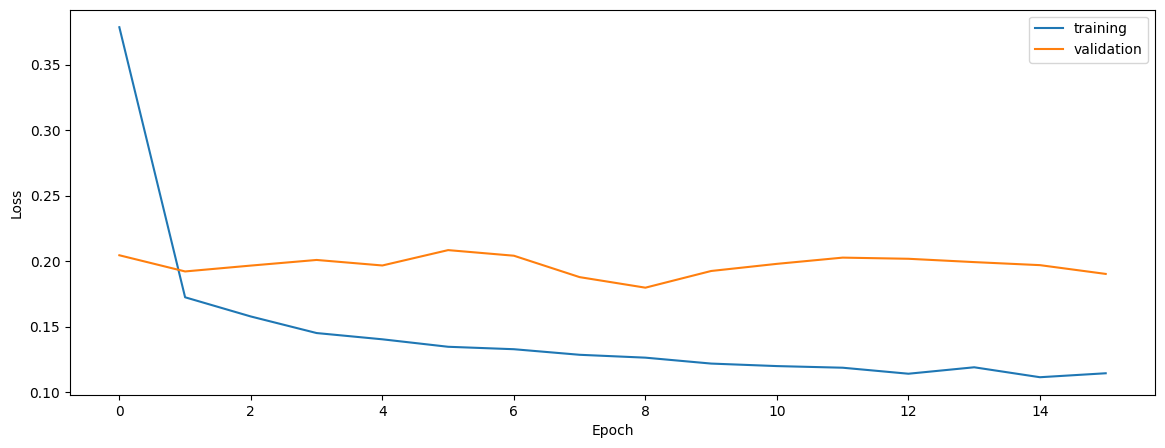

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('train')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

train


0.9515781871451948


0.9335373285273448


0.9370506249357636


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

native


0.9599667511200051


0.9383982878073952


0.9470626359890746


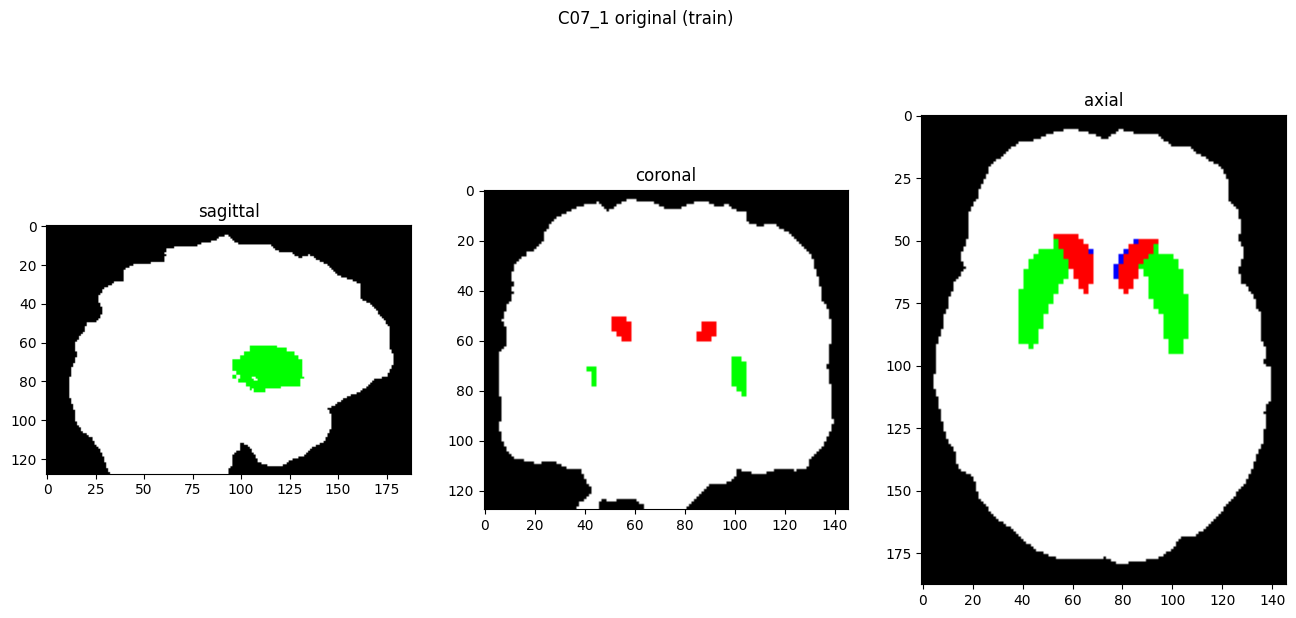

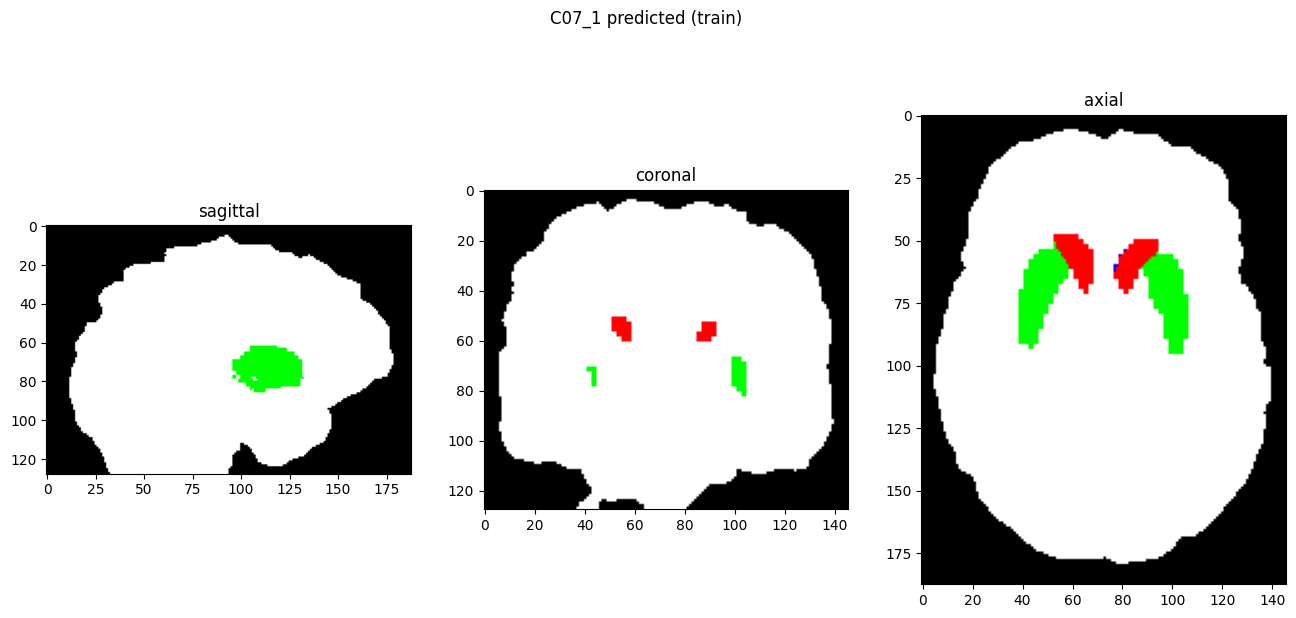

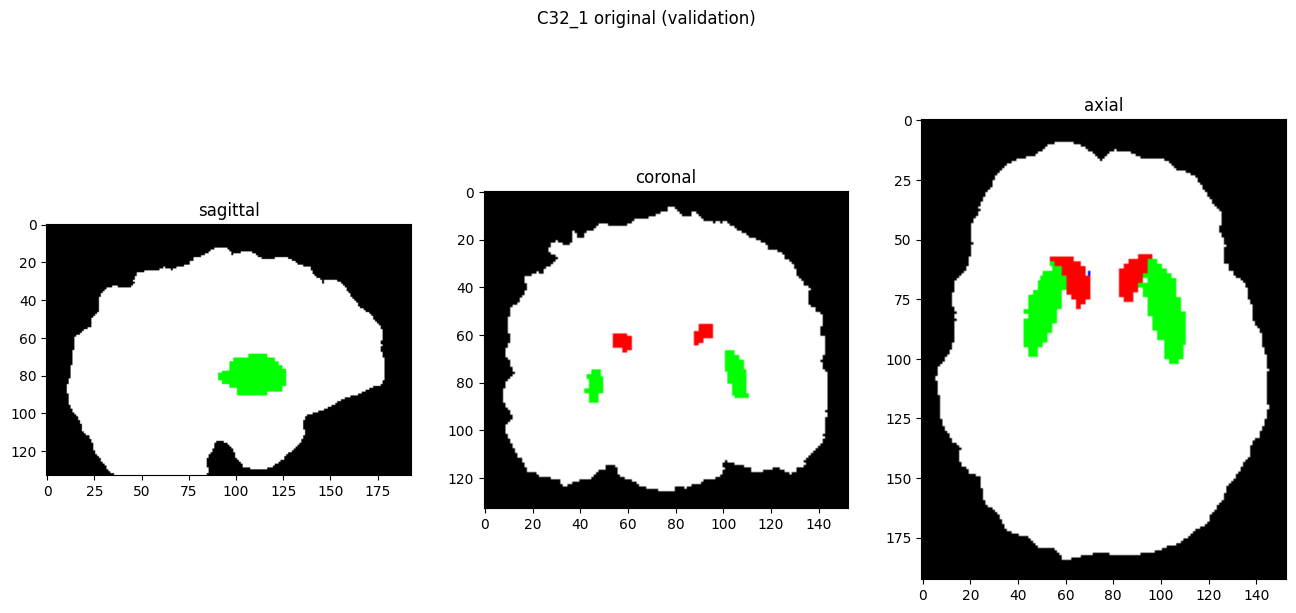

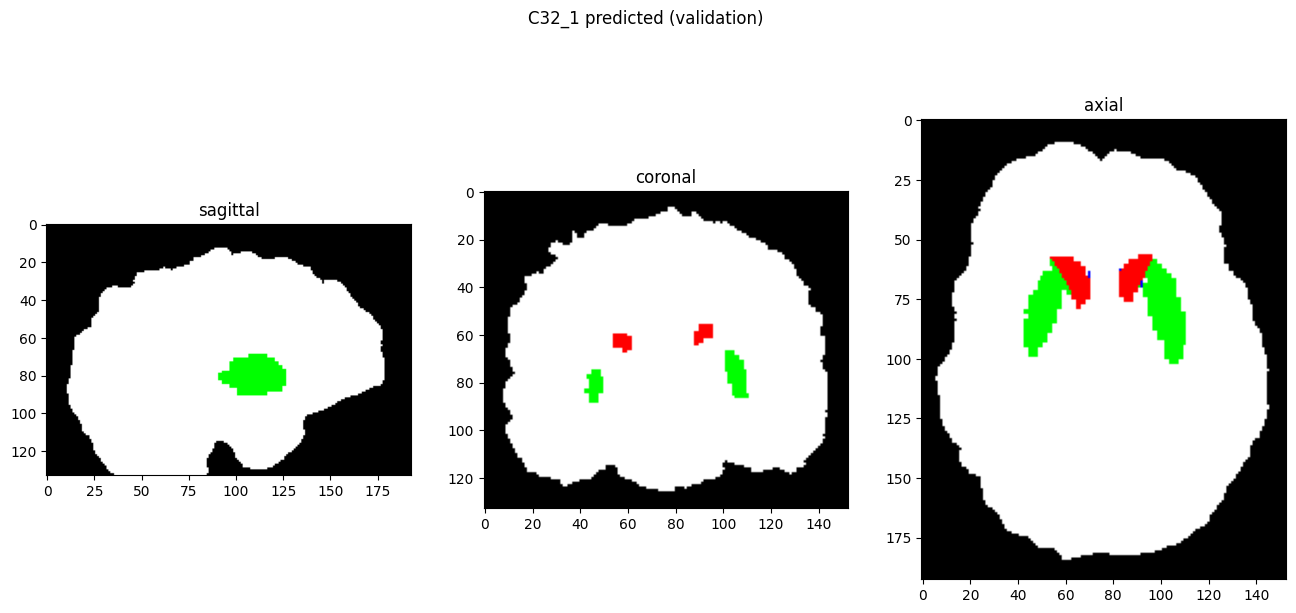

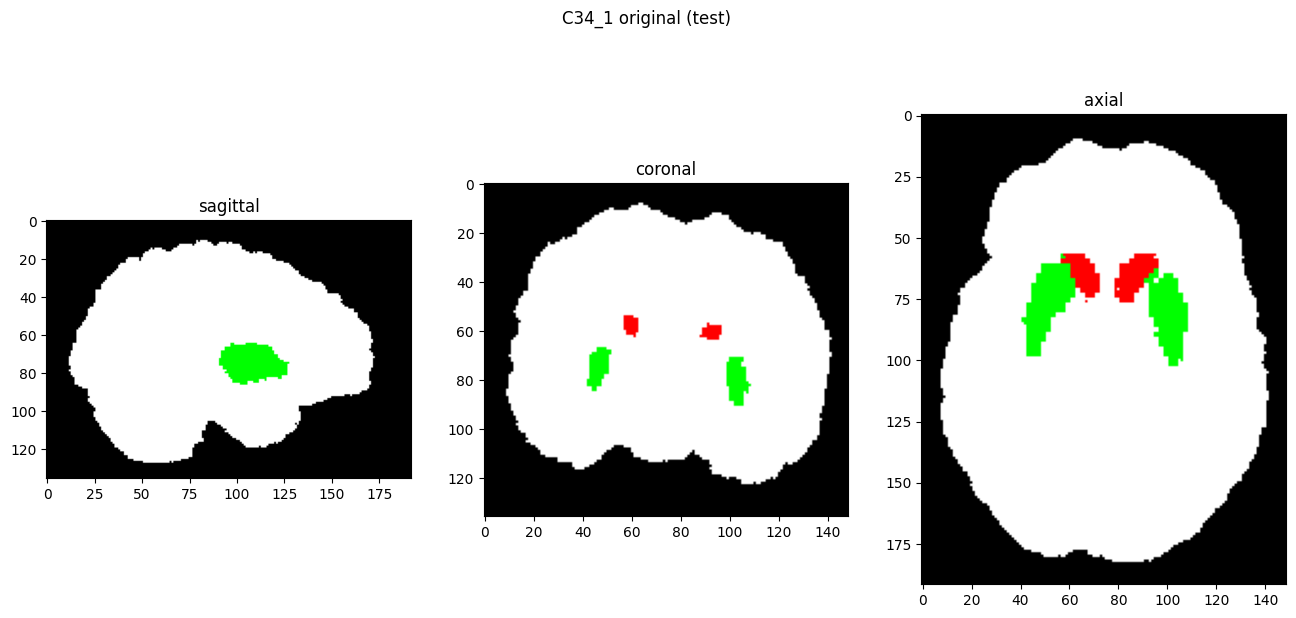

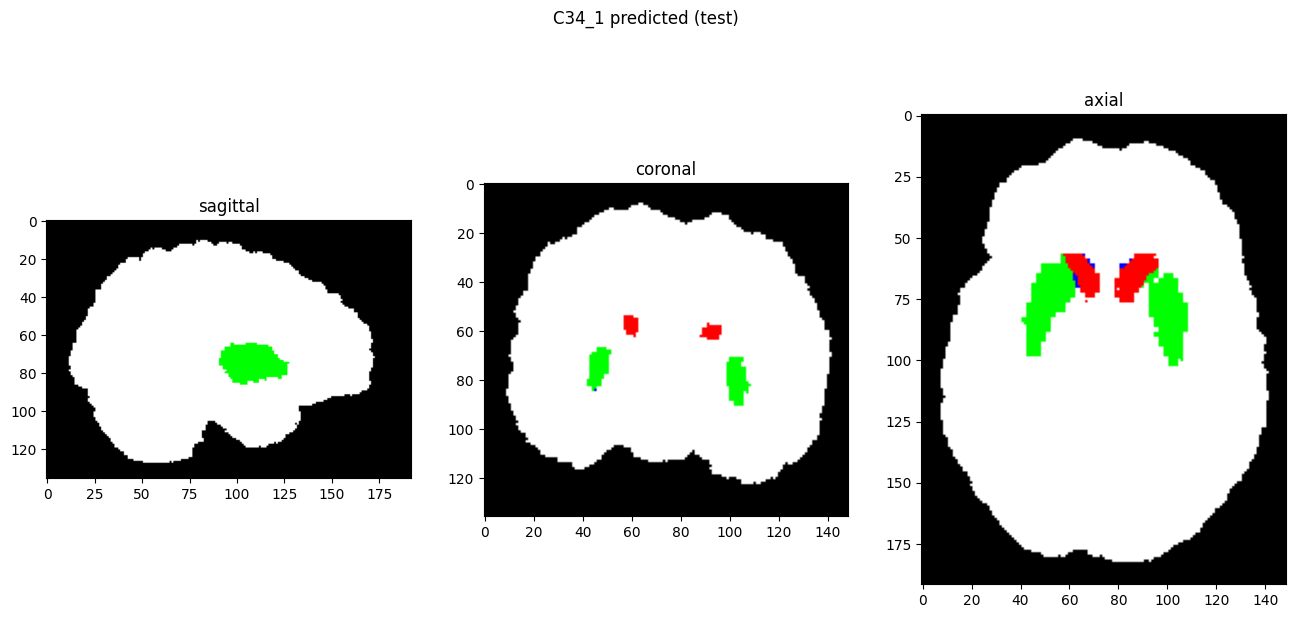

In [9]:
showResults(model, gen, threshold=0)